In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import warnings
import re
from datetime import datetime

In [2]:
# Ignore warnings
warnings.filterwarnings('ignore')

In [3]:
# Set display options for better visibility
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
# Set plot style and figure size
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (6, 4)


In [5]:
# Define helper functions for later use
def plot_distribution(df, column, title):
    """Plot distribution of numerical variables"""
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {title}')
    plt.show()

    plt.figure(figsize=(10, 2))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {title}')
    plt.show()

def plot_categorical(df, column, title):
    """Plot count of categorical variables"""
    plt.figure(figsize=(4, 3))
    sns.countplot(x=df[column])
    plt.title(f'Count of {title}')
    plt.show()

def plot_categorical_c(df, column, title):
    """Plot count of categorical variables"""
    plt.figure(figsize=(10, 4))
    df[column].value_counts().head(20).plot(kind = 'bar')
    plt.xticks(rotation=90)
    plt.title(f'Count of Top 20 {title}')
    plt.show()

def remove_outliers_iqr(df, column):
    """Remove outliers using IQR method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [6]:
def extract_location_features(location_str):
    """Extract city, place, code, and state from location strings"""
    try:
        if pd.isna(location_str):
            return pd.Series([np.nan, np.nan, np.nan, np.nan], index=['city', 'place', 'code', 'state'])

        # Extract state from parentheses
        state_pattern = r'\(([^)]+)\)'
        state_match = re.search(state_pattern, location_str)
        state = state_match.group(1).strip() if state_match else np.nan

        # Remove the state part for processing the rest
        location_without_state = re.sub(r'\([^)]+\)', '', location_str).strip()

        # Split by underscores
        parts = [part.strip() for part in location_without_state.split('_') if part.strip()]

        city = parts[0] if len(parts) > 0 else np.nan
        place = parts[1] if len(parts) > 1 else np.nan
        code = parts[2] if len(parts) > 2 else np.nan

        return pd.Series([city, place, code, state], index=['city', 'place', 'code', 'state'])
    except Exception as e:
        print(f"Error extracting features from '{location_str}': {e}")
        return pd.Series([np.nan, np.nan, np.nan, np.nan], index=['city', 'place', 'code', 'state'])


In [7]:
print("Starting Delhivery Feature Engineering Case Study...")

# Load the dataset
try:
    df = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv')
    print(f"Dataset loaded successfully with shape: {df.shape}")
except Exception as e:
    print(f"Error loading dataset: {e}")

Starting Delhivery Feature Engineering Case Study...
Dataset loaded successfully with shape: (144867, 24)


## **PART 1: EXPLORATORY DATA ANALYSIS**

In [8]:
# Display basic information about the dataset
print("\n1.1 General Dataset Information:")


1.1 General Dataset Information:


In [9]:
print(f"Number of records: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

Number of records: 144867
Number of features: 24


In [10]:
# Display data types and check for missing values
print("\n1.2 Data Types and Missing Values:")


1.2 Data Types and Missing Values:


In [11]:
print(df.dtypes)
print("\nMissing Values Count:")
print(df.isnull().sum())
print("\nMissing Values Percentage:")
print((df.isnull().sum() / len(df)) * 100)

data                               object
trip_creation_time                 object
route_schedule_uuid                object
route_type                         object
trip_uuid                          object
source_center                      object
source_name                        object
destination_center                 object
destination_name                   object
od_start_time                      object
od_end_time                        object
start_scan_to_end_scan            float64
is_cutoff                            bool
cutoff_factor                       int64
cutoff_timestamp                   object
actual_distance_to_destination    float64
actual_time                       float64
osrm_time                         float64
osrm_distance                     float64
factor                            float64
segment_actual_time               float64
segment_osrm_time                 float64
segment_osrm_distance             float64
segment_factor                    

In [12]:
# Convert data types
print("\n1.3 Converting Data Types:")


1.3 Converting Data Types:


In [13]:
# Convert timestamp columns to datetime
datetime_columns = ['trip_creation_time', 'od_start_time', 'od_end_time', 'cutoff_timestamp']
for col in datetime_columns:
    if col in df.columns:
        try:
            df[col] = pd.to_datetime(df[col])
            print(f"Converted {col} to datetime")
        except:
            print(f"Could not convert {col} to datetime")

Converted trip_creation_time to datetime
Converted od_start_time to datetime
Converted od_end_time to datetime
Could not convert cutoff_timestamp to datetime


In [14]:
# Display basic statistics
print("\n1.4 Basic Statistics:")
df.describe().T


1.4 Basic Statistics:


count                           mean  \
trip_creation_time                144867  2018-09-22 13:34:23.659819264   
od_start_time                     144867  2018-09-22 18:02:45.855230720   
od_end_time                       144867  2018-09-23 10:04:31.395393024   
start_scan_to_end_scan         144867.00                         961.26   
cutoff_factor                  144867.00                         232.93   
actual_distance_to_destination 144867.00                         234.07   
actual_time                    144867.00                         416.93   
osrm_time                      144867.00                         213.87   
osrm_distance                  144867.00                         284.77   
factor                         144867.00                           2.12   
segment_actual_time            144867.00                          36.20   
segment_osrm_time              144867.00                          18.51   
segment_osrm_distance          144867.00                          22.83   
segment_factor                 144867.00                           2.22   

                                                       min  \
trip_creation_time              2018-09-12 00:00:16.535741   
od_start_time                   2018-09-12 00:00:16.535741   
od_end_time                     2018-09-12 00:50:10.814399   
start_scan_to_end_scan                               20.00   
cutoff_factor                                         9.00   
actual_distance_to_destination                        9.00   
actual_time                                           9.00   
osrm_time                                             6.00   
osrm_distance                                         9.01   
factor                                                0.14   
segment_actual_time                                -244.00   
segment_osrm_time                                     0.00   
segment_osrm_distance                                 0.00   
segment_factor                                      -23.44   

                                                          25%  \
trip_creation_time              2018-09-17 03:20:51.775845888   
od_start_time                   2018-09-17 08:05:40.886155008   
od_end_time                     2018-09-18 01:48:06.410121984   
start_scan_to_end_scan                                 161.00   
cutoff_factor                                           22.00   
actual_distance_to_destination                          23.36   
actual_time                                             51.00   
osrm_time                                               27.00   
osrm_distance                                           29.91   
factor                                                   1.60   
segment_actual_time                                     20.00   
segment_osrm_time                                       11.00   
segment_osrm_distance                                   12.07   
segment_factor                                           1.35   

                                                          50%  \
trip_creation_time              2018-09-22 04:24:27.932764928   
od_start_time                   2018-09-22 08:53:00.116656128   
od_end_time                     2018-09-23 03:13:03.520212992   
start_scan_to_end_scan                                 449.00   
cutoff_factor                                           66.00   
actual_distance_to_destination                          66.13   
actual_time                                            132.00   
osrm_time                                               64.00   
osrm_distance                                           78.53   
factor                                                   1.86   
segment_actual_time                                     29.00   
segment_osrm_time                                       17.00   
segment_osrm_distance                                   23.51   
segment_factor                                           1.68   

                          

In [15]:
# Visualize data distributions for numerical columns
print("\n1.5 Distribution Analysis:")


1.5 Distribution Analysis:


In [16]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(f"Numerical columns to analyze: {numerical_columns}")

Numerical columns to analyze: ['start_scan_to_end_scan', 'cutoff_factor', 'actual_distance_to_destination', 'actual_time', 'osrm_time', 'osrm_distance', 'factor', 'segment_actual_time', 'segment_osrm_time', 'segment_osrm_distance', 'segment_factor']


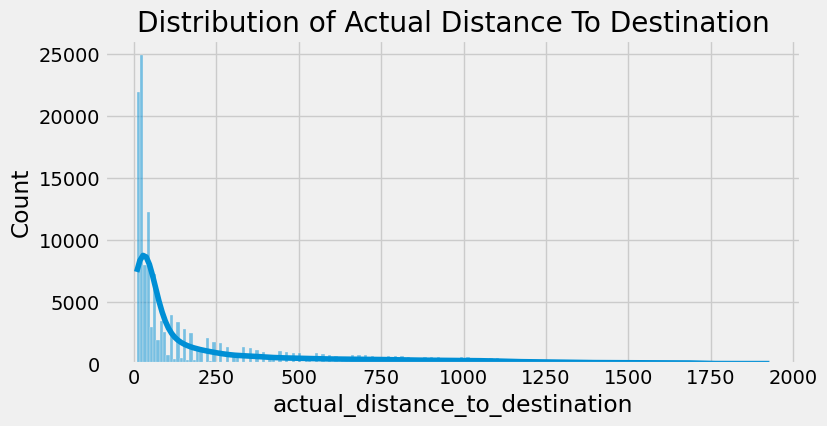

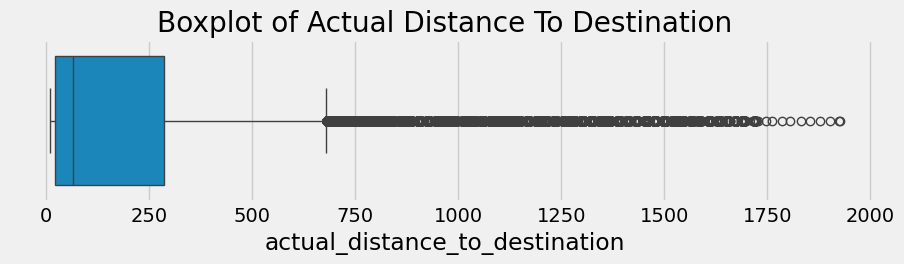

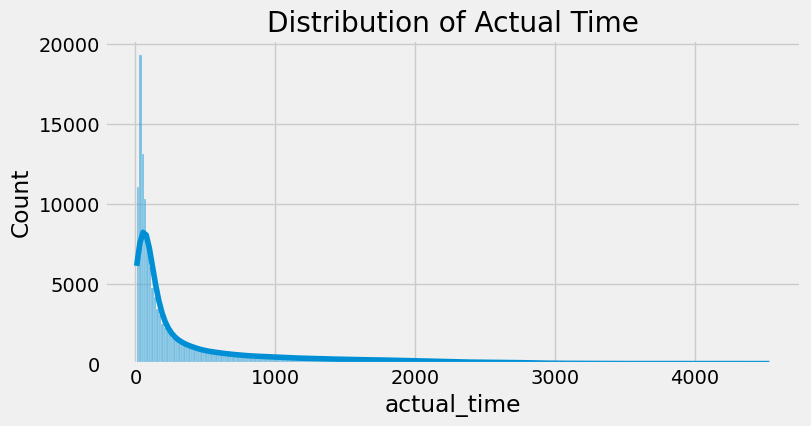

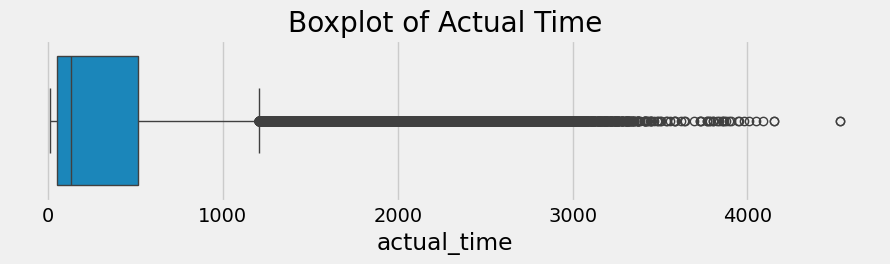

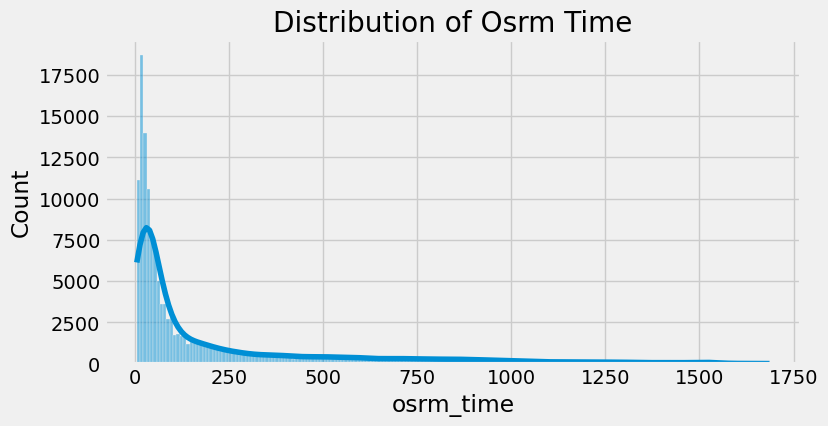

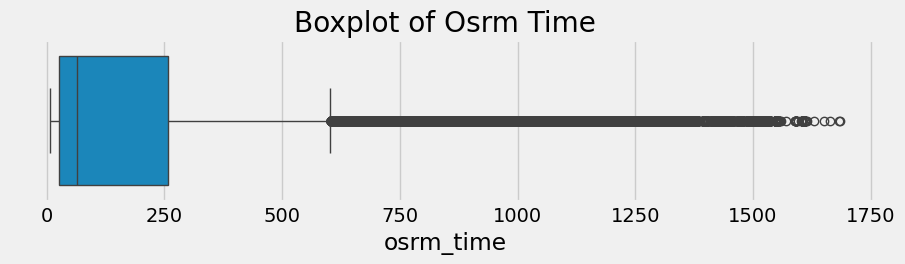

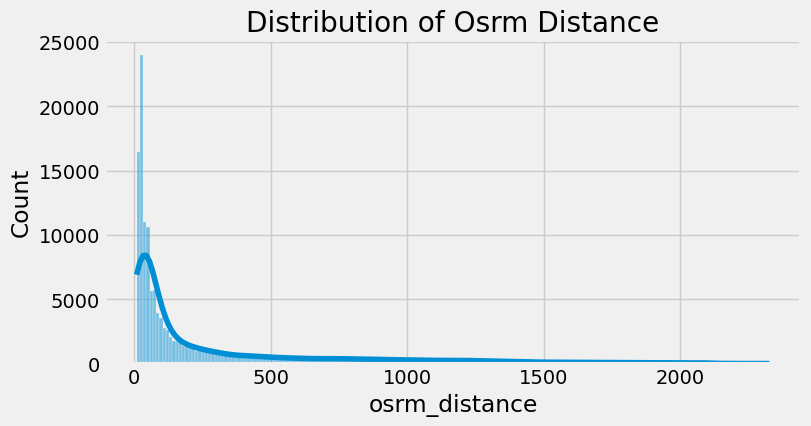

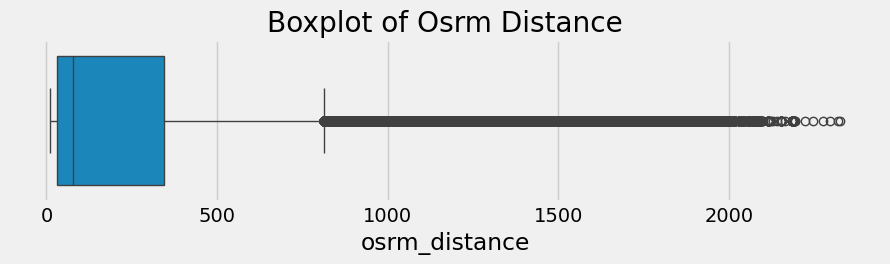

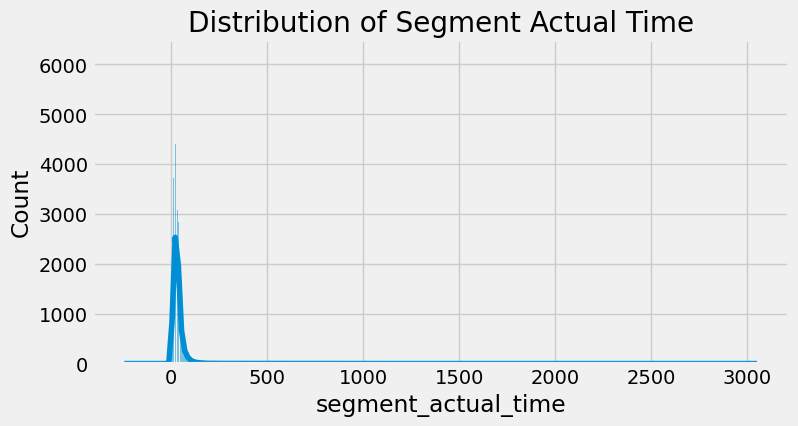

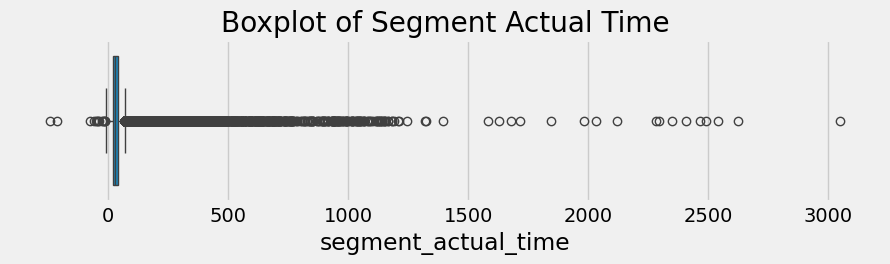

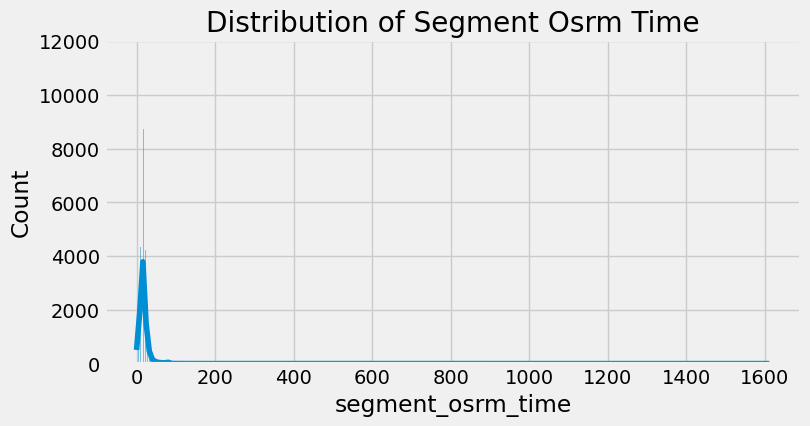

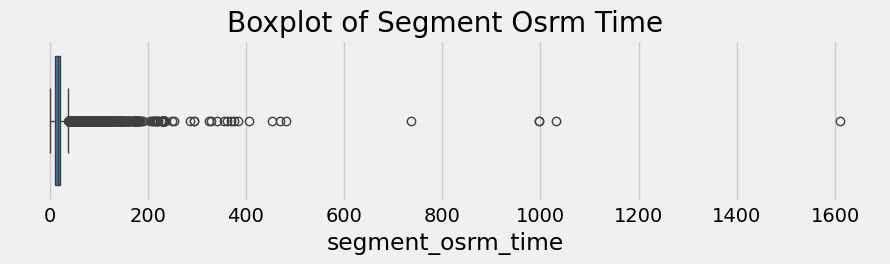

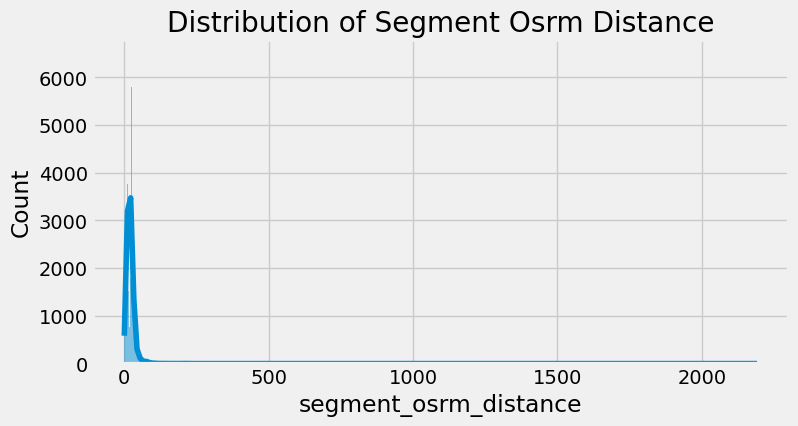

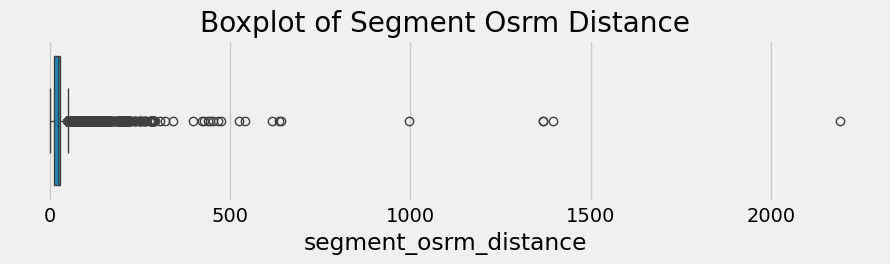

In [17]:
# Select a subset of numerical columns for visualization
viz_columns = ['actual_distance_to_destination', 'actual_time', 'osrm_time',
               'osrm_distance', 'segment_actual_time', 'segment_osrm_time', 'segment_osrm_distance']

for col in viz_columns:
    if col in df.columns:
        plot_distribution(df, col, col.replace('_', ' ').title())

In [18]:
# Visualize categorical columns
print("\n1.6 Categorical Analysis:")


1.6 Categorical Analysis:


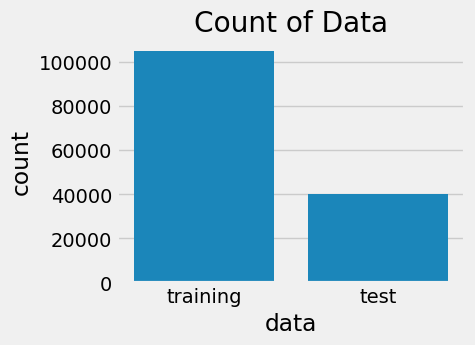

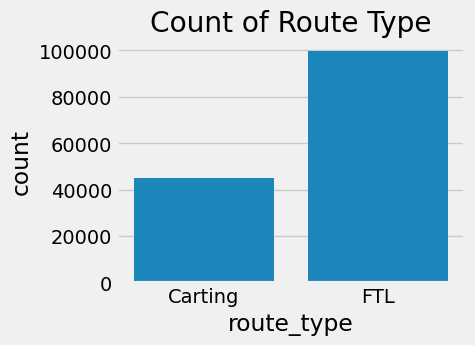

In [19]:
categorical_columns = ['data', 'route_type']
for col in categorical_columns:
    if col in df.columns:
        plot_categorical(df, col, col.replace('_', ' ').title())

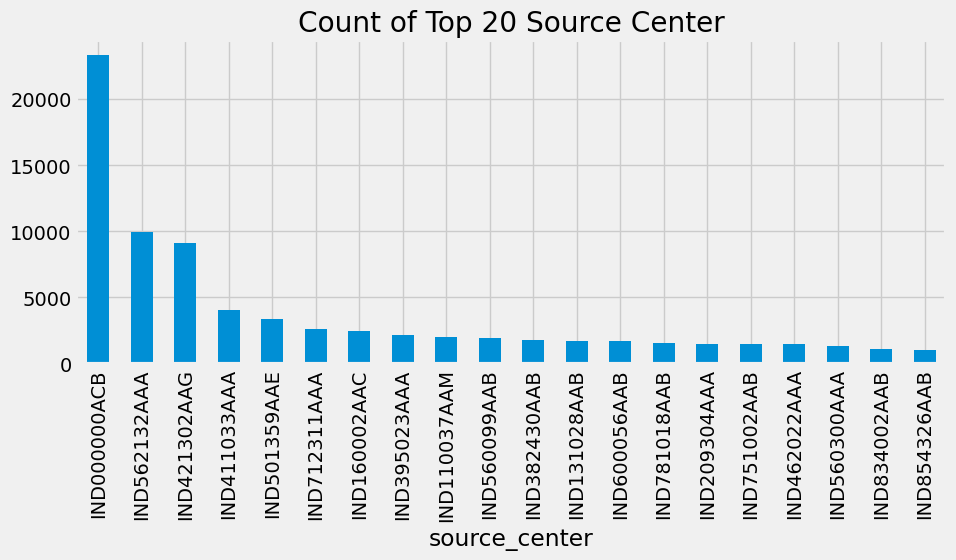

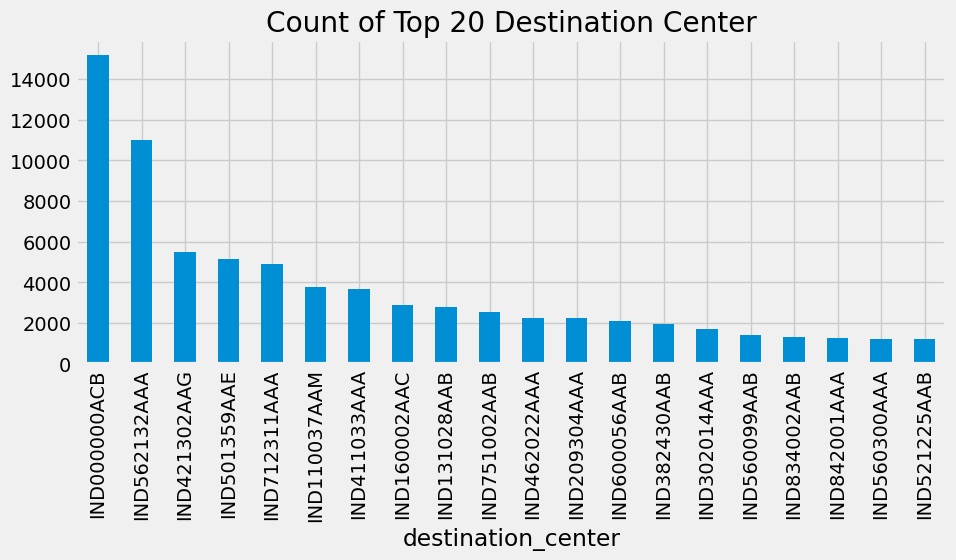

In [20]:
categorical_columns = ['source_center', 'destination_center']
for col in categorical_columns:
    if col in df.columns:
        plot_categorical_c(df, col, col.replace('_', ' ').title())

In [21]:
# Correlation and Skewness
print("\n1.7 Correlation and Skewness Analysis:")


1.7 Correlation and Skewness Analysis:


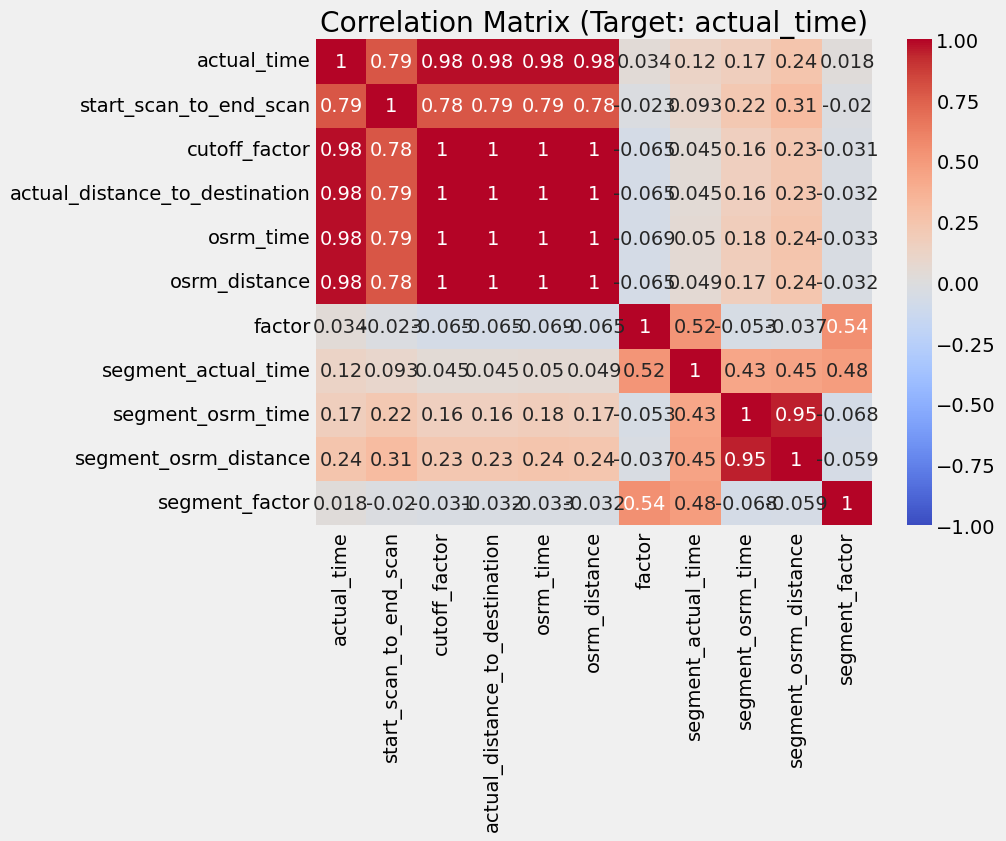

In [22]:
# Select numeric columns and calculate correlation matrix
corr_matrix = df[numerical_columns].corr()

# Reorder columns to put 'actual_time' first
columns_order = ['actual_time'] + [col for col in corr_matrix.columns if col != 'actual_time']
corr_matrix = corr_matrix.reindex(columns=columns_order, index=columns_order)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix (Target: actual_time)')
plt.show()

Skewness of numeric features:


segment_factor                   47.37
segment_osrm_distance            26.59
segment_osrm_time                19.64
factor                           17.49
segment_actual_time              16.83
actual_time                       2.07
osrm_distance                     2.05
osrm_time                         2.05
cutoff_factor                     1.99
actual_distance_to_destination    1.99
start_scan_to_end_scan            1.11
dtype: float64

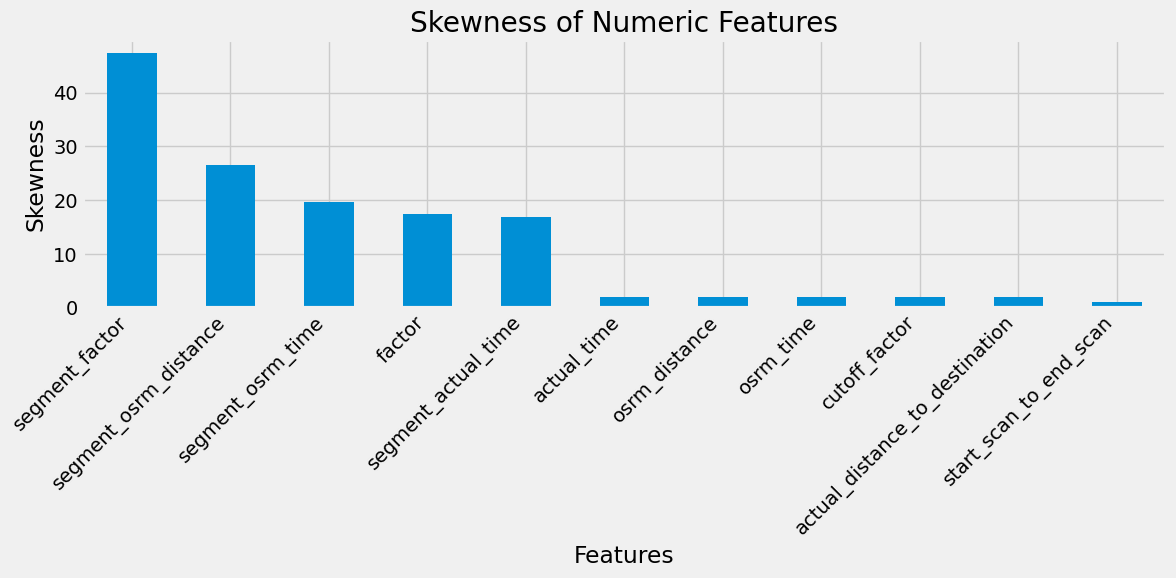

In [23]:
# Calculate skewness for numeric columns
skewness = df[numerical_columns].skew().sort_values(ascending=False)

print("Skewness of numeric features:")
display(skewness)

# Visualize skewness
plt.figure(figsize=(12, 6))
skewness.plot(kind='bar')
plt.title('Skewness of Numeric Features')
plt.xlabel('Features')
plt.ylabel('Skewness')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **PART 2: DATA PREPROCESSING AND FEATURE CREATION**

In [24]:
# Handle missing values
print("\n2.1 Handling Missing Values:")
# For numeric columns, fill with mean or median (for skewed distributions)
for col in numerical_columns:
    if df[col].isnull().sum() > 0:
        # Check for skewness
        skewness = df[col].skew()
        if abs(skewness) > 1:  # Highly skewed
            df[col].fillna(df[col].median(), inplace=True)
            print(f"Filled {col} nulls with median due to skewness ({skewness:.2f})")
        else:
            df[col].fillna(df[col].mean(), inplace=True)
            print(f"Filled {col} nulls with mean")


2.1 Handling Missing Values:


In [25]:
# For categorical columns, fill with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)
        print(f"Filled {col} nulls with mode")

Filled source_name nulls with mode
Filled destination_name nulls with mode


In [26]:
# Check remaining nulls
remaining_nulls = df.isnull().sum()
print("\nRemaining nulls after treatment:")
print(remaining_nulls[remaining_nulls > 0])


Remaining nulls after treatment:
Series([], dtype: int64)


In [27]:
# Create new features from existing columns
print("\n2.2 Feature Engineering:")


2.2 Feature Engineering:


In [28]:
# Extract datetime features from trip_creation_time
if 'trip_creation_time' in df.columns and pd.api.types.is_datetime64_any_dtype(df['trip_creation_time']):
    df['creation_year'] = df['trip_creation_time'].dt.year
    df['creation_month'] = df['trip_creation_time'].dt.month
    df['creation_day'] = df['trip_creation_time'].dt.day
    df['creation_hour'] = df['trip_creation_time'].dt.hour
    df['creation_dayofweek'] = df['trip_creation_time'].dt.dayofweek
    df['is_weekend'] = df['creation_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    print("Created datetime features from trip_creation_time")

Created datetime features from trip_creation_time


In [29]:
# Calculate time difference between od_start_time and od_end_time
if 'od_start_time' in df.columns and 'od_end_time' in df.columns:
      df['od_time_diff_hour'] = (df['od_end_time'] - df['od_start_time']).dt.total_seconds() / 3600
      print("Calculated time difference between od_start_time and od_end_time")

Calculated time difference between od_start_time and od_end_time


In [30]:
# Extract features from source_name and destination_name
if 'source_name' in df.columns:
    source_features = df['source_name'].apply(extract_location_features)
    df['source_city'] = source_features['city']
    df['source_place'] = source_features['place']
    df['source_code'] = source_features['code']
    df['source_state'] = source_features['state']
    print("Extracted features from source_name")

Extracted features from source_name


In [31]:
if 'destination_name' in df.columns:
    dest_features = df['destination_name'].apply(extract_location_features)
    df['destination_city'] = dest_features['city']
    df['destination_place'] = dest_features['place']
    df['destination_code'] = dest_features['code']
    df['destination_state'] = dest_features['state']
    print("Extracted features from destination_name")

Extracted features from destination_name


In [32]:
print("\nChecking extracted state values:")
print("Sample source_name values:")
print(df['source_name'].head(5))
print("\nExtracted source_state values:")
print(df['source_state'].head(5))
print(f"Null values in source_state: {df['source_state'].isnull().sum()}/{len(df)}")

print("\nSample destination_name values:")
print(df['destination_name'].head(5))
print("\nExtracted destination_state values:")
print(df['destination_state'].head(5))
print(f"Null values in destination_state: {df['destination_state'].isnull().sum()}/{len(df)}")


Checking extracted state values:
Sample source_name values:
0    Anand_VUNagar_DC (Gujarat)
1    Anand_VUNagar_DC (Gujarat)
2    Anand_VUNagar_DC (Gujarat)
3    Anand_VUNagar_DC (Gujarat)
4    Anand_VUNagar_DC (Gujarat)
Name: source_name, dtype: object

Extracted source_state values:
0    Gujarat
1    Gujarat
2    Gujarat
3    Gujarat
4    Gujarat
Name: source_state, dtype: object
Null values in source_state: 0/144867

Sample destination_name values:
0    Khambhat_MotvdDPP_D (Gujarat)
1    Khambhat_MotvdDPP_D (Gujarat)
2    Khambhat_MotvdDPP_D (Gujarat)
3    Khambhat_MotvdDPP_D (Gujarat)
4    Khambhat_MotvdDPP_D (Gujarat)
Name: destination_name, dtype: object

Extracted destination_state values:
0    Gujarat
1    Gujarat
2    Gujarat
3    Gujarat
4    Gujarat
Name: destination_state, dtype: object
Null values in destination_state: 0/144867


In [33]:
# Enhanced Feature Engineering - Calculate additional derived metrics
print("\n2.3 Enhanced Feature Engineering:")


2.3 Enhanced Feature Engineering:


In [34]:
# Calculate speed metrics (distance/time)
# Adding small epsilon to avoid division by zero
epsilon = 1e-10

In [35]:
# Calculate speed metrics
if all(col in df.columns for col in ['actual_distance_to_destination', 'actual_time']):
    df['actual_speed'] = df['actual_distance_to_destination'] / (df['actual_time'] + epsilon)
    print("Created actual_speed feature (km/hour)")

if all(col in df.columns for col in ['osrm_distance', 'osrm_time']):
    df['osrm_speed'] = df['osrm_distance'] / (df['osrm_time'] + epsilon)
    print("Created osrm_speed feature (km/hour)")

if all(col in df.columns for col in ['segment_osrm_distance', 'segment_osrm_time']):
    df['segment_osrm_speed'] = df['segment_osrm_distance'] / (df['segment_osrm_time'] + epsilon)
    print("Created segment_osrm_speed feature (km/hour)")

if all(col in df.columns for col in ['segment_osrm_distance', 'segment_actual_time']):
    df['segment_actual_speed'] = df['segment_osrm_distance'] / (df['segment_actual_time'] + epsilon)
    print("Created segment_actual_speed feature (km/hour)")

Created actual_speed feature (km/hour)
Created osrm_speed feature (km/hour)
Created segment_osrm_speed feature (km/hour)
Created segment_actual_speed feature (km/hour)


In [36]:
# Calculate delay metrics
if all(col in df.columns for col in ['actual_time', 'osrm_time']):
    df['delay_time'] = df['actual_time'] - df['osrm_time']
    df['delay_time_pct'] = (df['delay_time'] / (df['osrm_time'] + epsilon)) * 100
    print("Created delay_time and delay_time_pct features")

if all(col in df.columns for col in ['segment_actual_time', 'segment_osrm_time']):
    df['segment_delay_time'] = df['segment_actual_time'] - df['segment_osrm_time']
    df['segment_delay_time_pct'] = (df['segment_delay_time'] / (df['segment_osrm_time'] + epsilon)) * 100
    print("Created segment_delay_time and segment_delay_time_pct features")

Created delay_time and delay_time_pct features
Created segment_delay_time and segment_delay_time_pct features


In [37]:
# Calculate time efficiency ratio
if all(col in df.columns for col in ['start_scan_to_end_scan', 'actual_time']):
    df['time_efficiency_ratio'] = df['start_scan_to_end_scan'] / (df['actual_time'] + epsilon)
    print("Created time_efficiency_ratio feature")

Created time_efficiency_ratio feature


In [38]:
# Create distance-based features
if all(col in df.columns for col in ['actual_distance_to_destination', 'osrm_distance']):
    df['distance_deviation'] = df['actual_distance_to_destination'] - df['osrm_distance']
    df['distance_deviation_pct'] = (df['distance_deviation'] / (df['osrm_distance'] + epsilon)) * 100
    print("Created distance_deviation and distance_deviation_pct features")

Created distance_deviation and distance_deviation_pct features


In [39]:
# Geographic distance features - calculate distances between city centers
# This requires a more complex approach with lat/long coordinates
# For now, we'll create a simple region feature based on states

# Create region mapping (based on Indian geography)
region_mapping = {
    'Gujarat': 'West',
    'Maharashtra': 'West',
    'Rajasthan': 'West',
    'Goa': 'West',

    'Uttar Pradesh': 'North',
    'Delhi': 'North',
    'Haryana': 'North',
    'Punjab': 'North',
    'Himachal Pradesh': 'North',
    'Uttarakhand': 'North',
    'Jammu and Kashmir': 'North',

    'Karnataka': 'South',
    'Tamil Nadu': 'South',
    'Kerala': 'South',
    'Andhra Pradesh': 'South',
    'Telangana': 'South',

    'West Bengal': 'East',
    'Bihar': 'East',
    'Odisha': 'East',
    'Jharkhand': 'East',
    'Assam': 'East',

    'Madhya Pradesh': 'Central',
    'Chhattisgarh': 'Central'
}

In [40]:
# Apply region mapping to source and destination states
if 'source_state' in df.columns:
    df['source_region'] = df['source_state'].map(region_mapping)
    print("Created source_region feature")

if 'destination_state' in df.columns:
    df['destination_region'] = df['destination_state'].map(region_mapping)
    print("Created destination_region feature")

Created source_region feature
Created destination_region feature


In [41]:
# Create region corridor feature
if all(col in df.columns for col in ['source_region', 'destination_region']):
    df['region_corridor'] = df['source_region'] + ' to ' + df['destination_region']
    print("Created region_corridor feature")

Created region_corridor feature


In [42]:
# Time of day features for better temporal analysis
if 'od_start_time' in df.columns and pd.api.types.is_datetime64_any_dtype(df['od_start_time']):
    # Create time of day categories
    df['start_hour'] = df['od_start_time'].dt.hour
    df['start_time_of_day'] = pd.cut(
        df['start_hour'],
        bins=[0, 6, 12, 18, 24],
        labels=['Night', 'Morning', 'Afternoon', 'Evening'],
        include_lowest=True
    )
    print("Created start_time_of_day feature")

if 'od_end_time' in df.columns and pd.api.types.is_datetime64_any_dtype(df['od_end_time']):
    df['end_hour'] = df['od_end_time'].dt.hour
    df['end_time_of_day'] = pd.cut(
        df['end_hour'],
        bins=[0, 6, 12, 18, 24],
        labels=['Night', 'Morning', 'Afternoon', 'Evening'],
        include_lowest=True
    )
    print("Created end_time_of_day feature")

Created start_time_of_day feature
Created end_time_of_day feature


In [43]:
# Creating segments for trips
print("\n2.4 Creating Trip Segments:")
# Create segment_key based on trip_uuid, source_center, and destination_center
df['segment_key'] = df['trip_uuid'] + '_' + df['source_center'].astype(str) + '_' + df['destination_center'].astype(str)


2.4 Creating Trip Segments:


In [44]:
# Grouping by segment and aggregating appropriate fields
create_segment_dict = {
    'data': 'first',
    'trip_creation_time': 'first',
    'route_schedule_uuid': 'first',
    'route_type': 'first',
    'source_name': 'first',
    'destination_name': 'first',
    'od_start_time': 'first',
    'od_end_time': 'last',  # Take the last end time for the segment
    'start_scan_to_end_scan': 'sum',  # Sum for cumulative time
    'is_cutoff': 'first',
    'cutoff_factor': 'first',
    'cutoff_timestamp': 'first',
    'actual_distance_to_destination': 'sum',
    'actual_time': 'sum',
    'osrm_time': 'sum',
    'osrm_distance': 'sum',
    'factor': 'mean',
    'segment_actual_time': 'sum',
    'segment_osrm_time': 'sum',
    'segment_osrm_distance': 'sum',
    'segment_factor': 'mean',
    'od_time_diff_hour': 'sum',
    'source_city': 'first',
    'source_place': 'first',
    'source_code': 'first',
    'source_state': 'first',
    'destination_city': 'first',
    'destination_place': 'first',
    'destination_code': 'first',
    'destination_state': 'first',
    'creation_year': 'first',
    'creation_month': 'first',
    'creation_day': 'first',
    'creation_hour': 'first',
    'creation_dayofweek': 'first',
    'is_weekend': 'first'
}



In [45]:
create_segment_dict.update({
    # Speed metrics
    'actual_speed': 'mean',
    'osrm_speed': 'mean',
    'segment_osrm_speed': 'mean',
    'segment_actual_speed': 'mean',

    # Delay metrics
    'delay_time': 'sum',
    'delay_time_pct': 'mean',
    'segment_delay_time': 'sum',
    'segment_delay_time_pct': 'mean',

    # Efficiency metrics
    'time_efficiency_ratio': 'mean',

    # Distance metrics
    'distance_deviation': 'sum',
    'distance_deviation_pct': 'mean',

    # Region information
    'source_region': 'first',
    'destination_region': 'first',
    'region_corridor': 'first',

    # Time of day
    'start_time_of_day': 'first',
    'end_time_of_day': 'last',
})

In [46]:
# Group by segment_key and apply aggregations
segment_df = df.groupby('segment_key').agg(create_segment_dict).reset_index()
print(f"Created segment level dataframe with shape: {segment_df.shape}")

Created segment level dataframe with shape: (26368, 53)


In [47]:
# Sort segments by segment_key and od_end_time
segment_df = segment_df.sort_values(['segment_key', 'od_end_time'])

In [48]:
# Extract 'trip_uuid' from 'segment_key'
segment_df['trip_uuid'] = segment_df['segment_key'].str.split('_').str[0]

In [49]:
# Calculate variance metrics for segments within each trip
print("\n2.5 Creating Variance Metrics for Performance Consistency:")


2.5 Creating Variance Metrics for Performance Consistency:


In [50]:
# Group segments by trip_uuid to calculate variance metrics
variance_metrics = segment_df.groupby('trip_uuid').agg({
    'actual_speed': ['std', 'max', 'min'],
    'delay_time_pct': ['std', 'max', 'min'],
    'segment_delay_time': ['std', 'max', 'min'],
    'time_efficiency_ratio': ['std', 'max', 'min']
})

# Flatten the MultiIndex columns
variance_metrics.columns = ['_'.join(col).strip() for col in variance_metrics.columns.values]
variance_metrics.reset_index(inplace=True)

print(f"Created variance metrics with shape: {variance_metrics.shape}")

# Add a performance consistency feature based on delay time variance
variance_metrics['performance_consistency'] = pd.cut(
    variance_metrics['delay_time_pct_std'],
    bins=[0, 10, 30, 50, float('inf')],
    labels=['Very Consistent', 'Consistent', 'Inconsistent', 'Very Inconsistent']
)


Created variance metrics with shape: (14817, 13)


In [51]:
# Aggregate trips
print("\n2.6 Aggregating at Trip Level:")


2.6 Aggregating at Trip Level:


In [52]:
create_trip_dict = {
    'data': 'first',
    'trip_creation_time': 'first',
    'route_schedule_uuid': 'first',
    'route_type': 'first',
    'source_name': 'first',  # First pickup
    'destination_name': 'last',  # Last delivery
    'od_start_time': 'first',  # Start of first segment
    'od_end_time': 'last',  # End of last segment
    'start_scan_to_end_scan': 'sum',
    'actual_distance_to_destination': 'sum',
    'actual_time': 'sum',
    'osrm_time': 'sum',
    'osrm_distance': 'sum',
    'segment_actual_time': 'sum',
    'segment_osrm_time': 'sum',
    'segment_osrm_distance': 'sum',
    'od_time_diff_hour': 'sum',
    'source_city': 'first',
    'source_place': 'first',
    'source_code': 'first',
    'source_state': 'first',
    'destination_city': 'last',
    'destination_place': 'last',
    'destination_code': 'last',
    'destination_state': 'last',
    'creation_year': 'first',
    'creation_month': 'first',
    'creation_day': 'first',
    'creation_hour': 'first',
    'creation_dayofweek': 'first',
    'is_weekend': 'first'
}




In [53]:
create_trip_dict.update({
    # Speed metrics
    'actual_speed': 'mean',
    'osrm_speed': 'mean',
    'segment_osrm_speed': 'mean',
    'segment_actual_speed': 'mean',

    # Delay metrics
    'delay_time': 'sum',
    'delay_time_pct': 'mean',
    'segment_delay_time': 'sum',
    'segment_delay_time_pct': 'mean',

    # Efficiency metrics
    'time_efficiency_ratio': 'mean',

    # Distance metrics
    'distance_deviation': 'sum',
    'distance_deviation_pct': 'mean',

    # Region information
    'source_region': 'first',
    'destination_region': 'last',
    'region_corridor': 'first',

    # Time of day
    'start_time_of_day': 'first',
    'end_time_of_day': 'last',
})

In [54]:
# Group by trip_uuid and apply aggregations
trip_df = segment_df.groupby('trip_uuid').agg(create_trip_dict).reset_index()
print(f"Created trip level dataframe with shape: {trip_df.shape}")

Created trip level dataframe with shape: (14817, 48)


## **PART 3: EXPLORATORY DATA ANALYSIS ON AGGREGATED DATA**

In [55]:
# Analyze the distribution of time and distance variables
print("\n3.1 Time and Distance Analysis:")


3.1 Time and Distance Analysis:


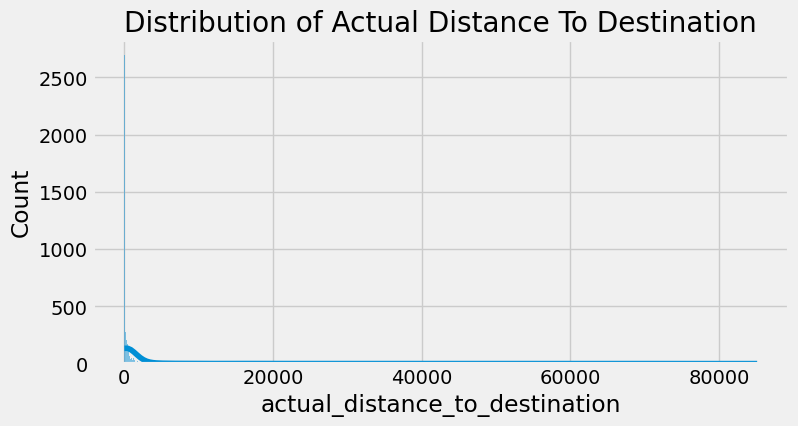

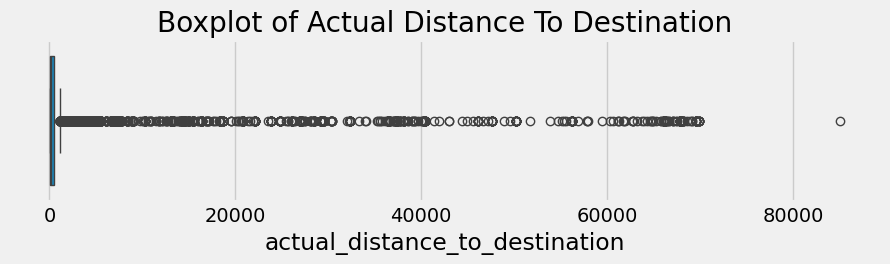

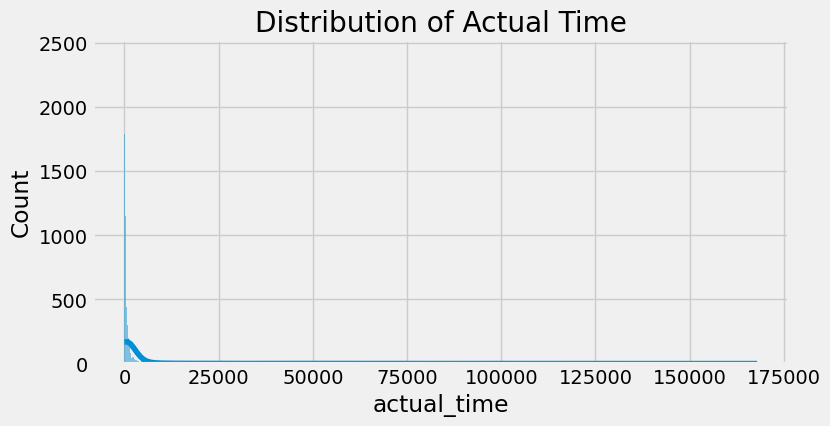

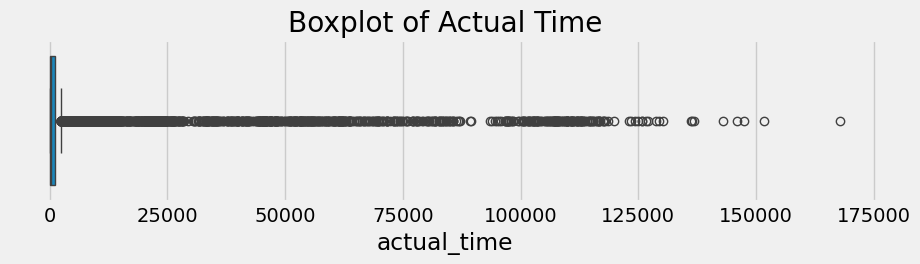

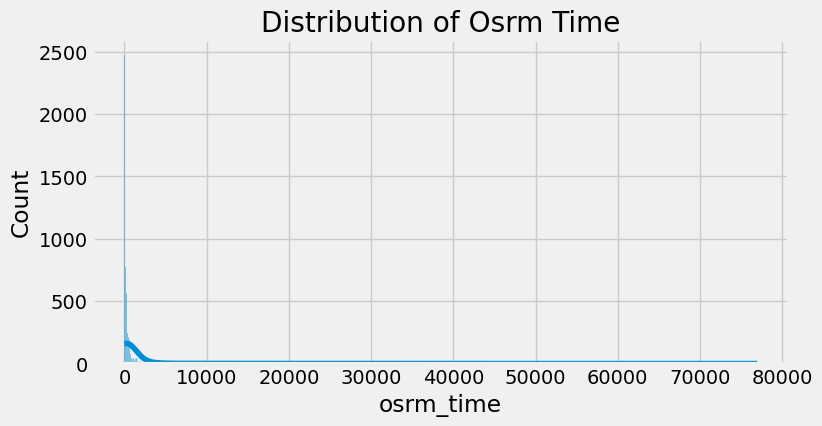

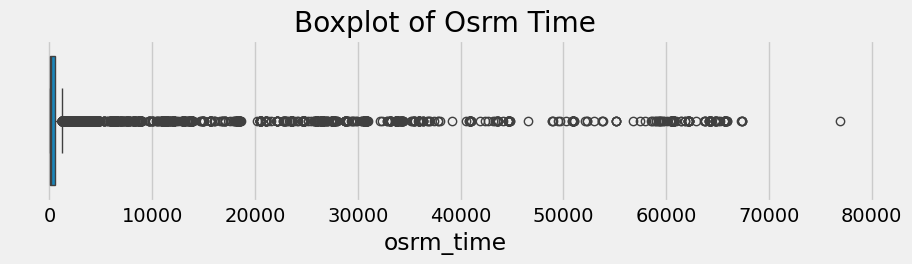

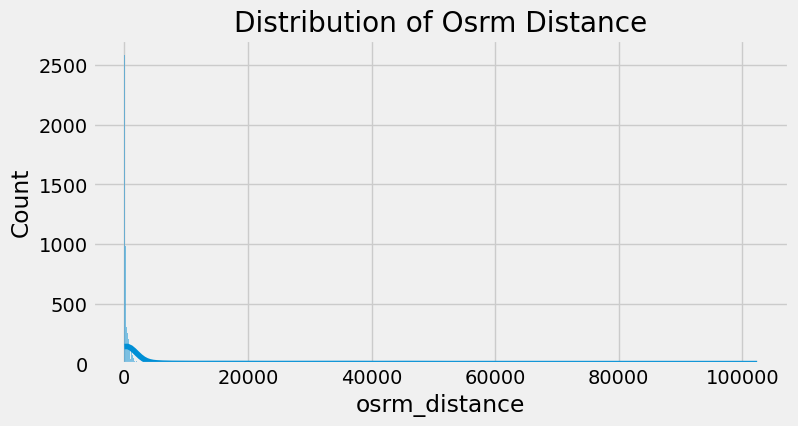

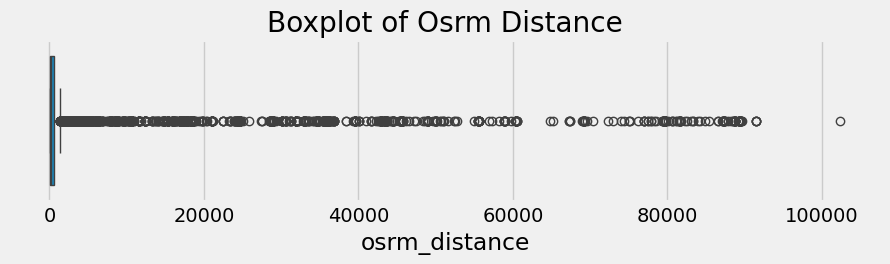

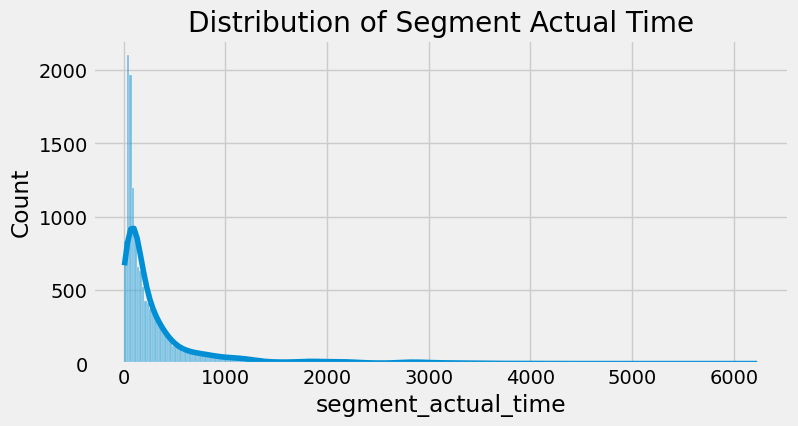

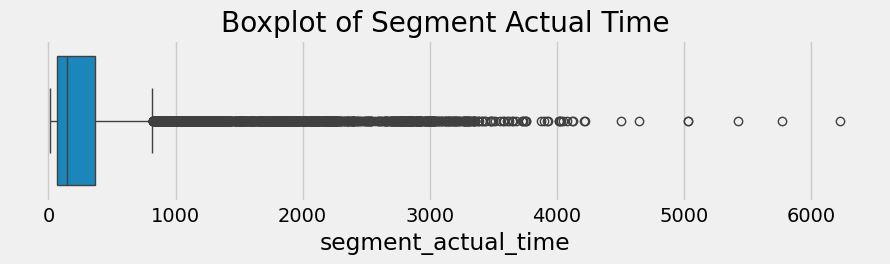

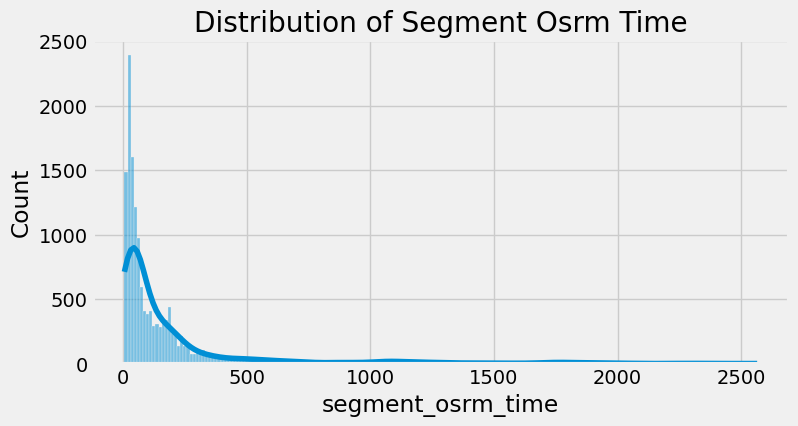

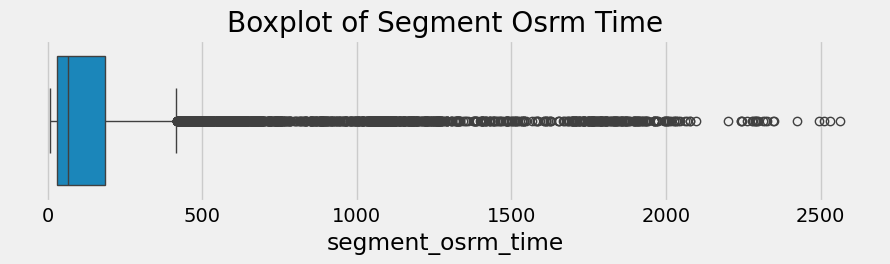

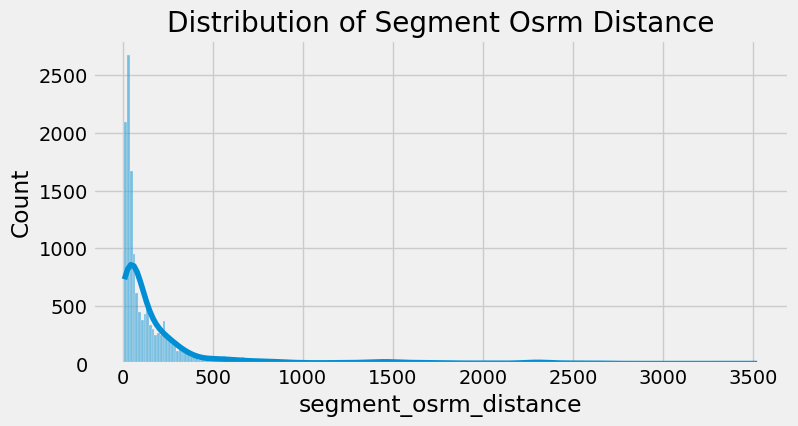

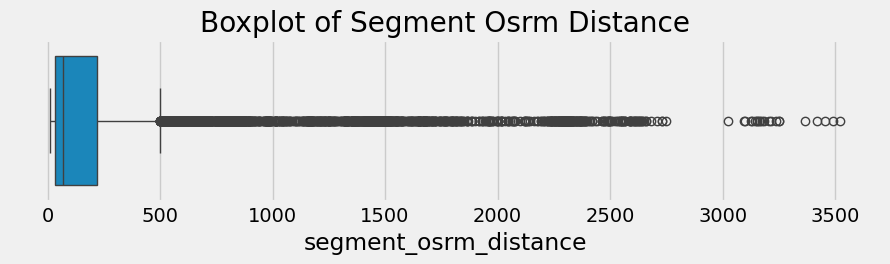

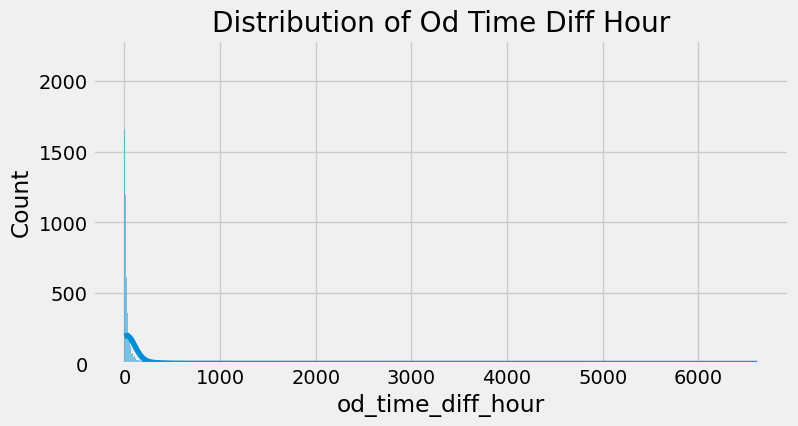

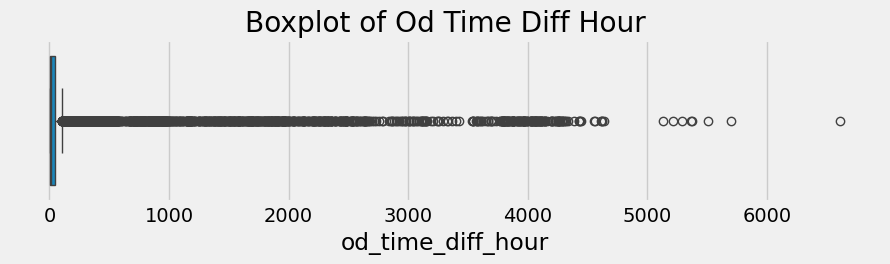

In [56]:
time_distance_cols = ['actual_distance_to_destination', 'actual_time', 'osrm_time', 'osrm_distance',
                      'segment_actual_time', 'segment_osrm_time', 'segment_osrm_distance', 'od_time_diff_hour']

for col in time_distance_cols:
    if col in trip_df.columns:
        plot_distribution(trip_df, col, col.replace('_', ' ').title())

In [57]:
# Hypothesis testing between actual and OSRM metrics
print("\n3.2 Hypothesis Testing:")


3.2 Hypothesis Testing:


In [58]:
# Function for performing t-test and visualizing differences
def compare_metrics(df, col1, col2, title1, title2):
    # T-test
    t_stat, p_val = stats.ttest_rel(df[col1], df[col2])
    print(f"T-test between {title1} and {title2}:")
    print(f"t-statistic: {t_stat:.4f}, p-value: {p_val:.8f}")
    if p_val < 0.05:
        print(f"Significant difference found between {title1} and {title2}")
    else:
        print(f"No significant difference found between {title1} and {title2}")

    # Visualization
    plt.figure(figsize=(17, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col1], color='blue', kde=True, label=title1)
    sns.histplot(df[col2], color='red', kde=True, label=title2)
    plt.title(f"Distribution of {title1} vs {title2}")
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=df[col1], y=df[col2])
    plt.plot([df[col1].min(), df[col1].max()], [df[col1].min(), df[col1].max()], 'r--')
    plt.xlabel(title1)
    plt.ylabel(title2)
    plt.title(f"Correlation between {title1} and {title2}")
    plt.tight_layout()
    plt.show()

    # Calculate correlation
    corr = df[col1].corr(df[col2])
    print(f"Correlation between {title1} and {title2}: {corr:.4f}")
    print()


T-test between Actual Time and OSRM Time:
t-statistic: 32.4681, p-value: 0.00000000
Significant difference found between Actual Time and OSRM Time


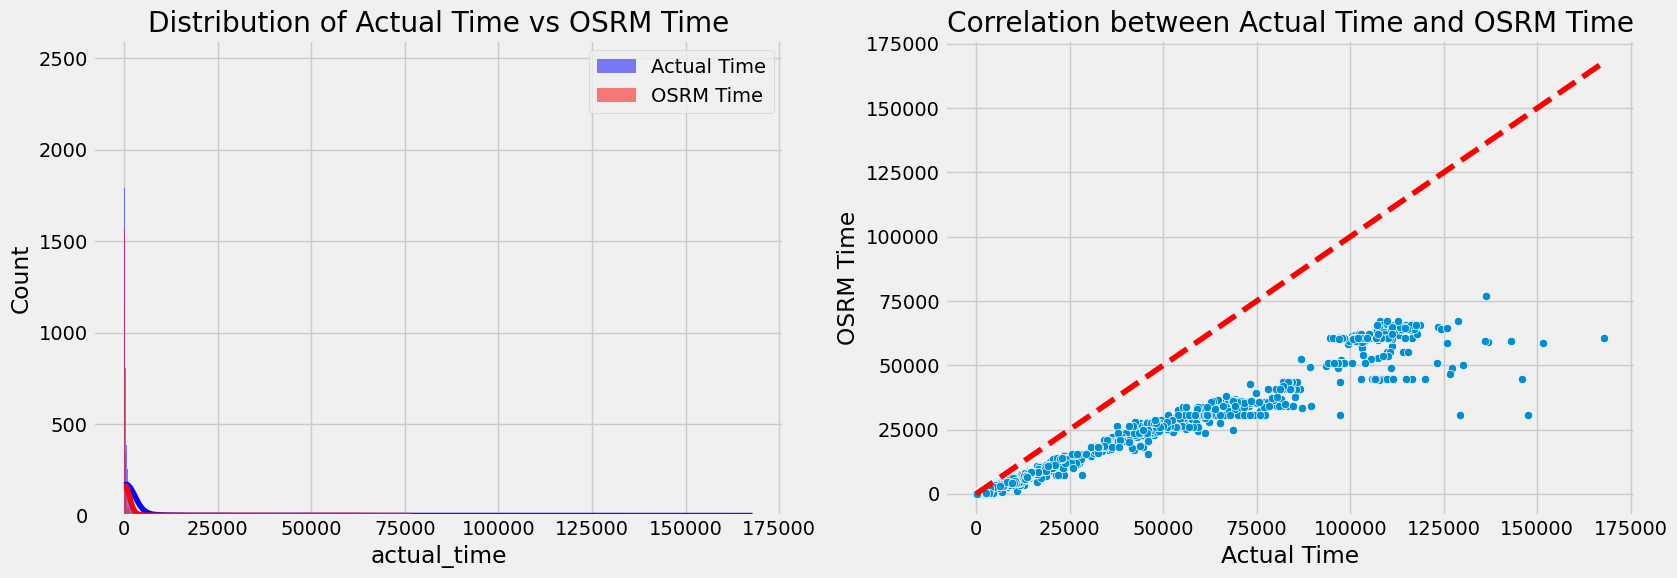

Correlation between Actual Time and OSRM Time: 0.9889

T-test between Actual Time and Segment Actual Time:
t-statistic: 30.7555, p-value: 0.00000000
Significant difference found between Actual Time and Segment Actual Time


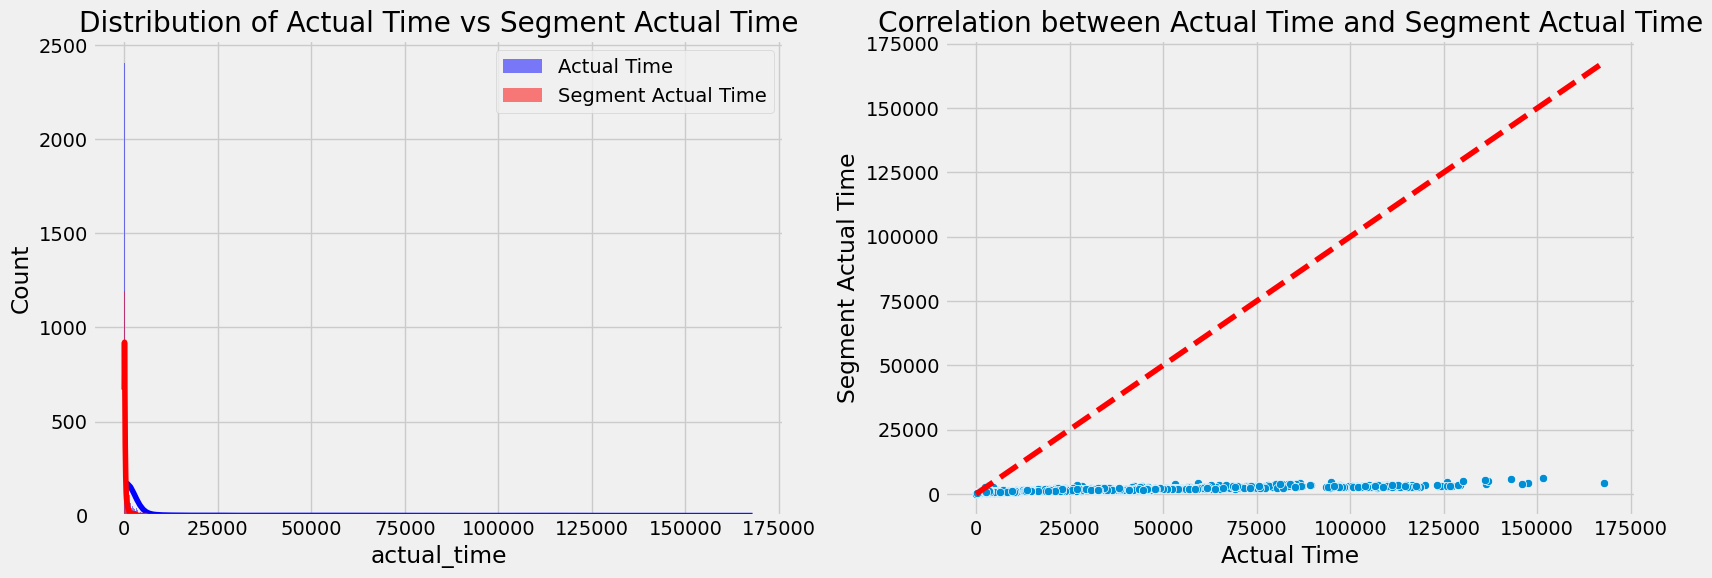

Correlation between Actual Time and Segment Actual Time: 0.8747

T-test between OSRM Distance and Segment OSRM Distance:
t-statistic: 30.0303, p-value: 0.00000000
Significant difference found between OSRM Distance and Segment OSRM Distance


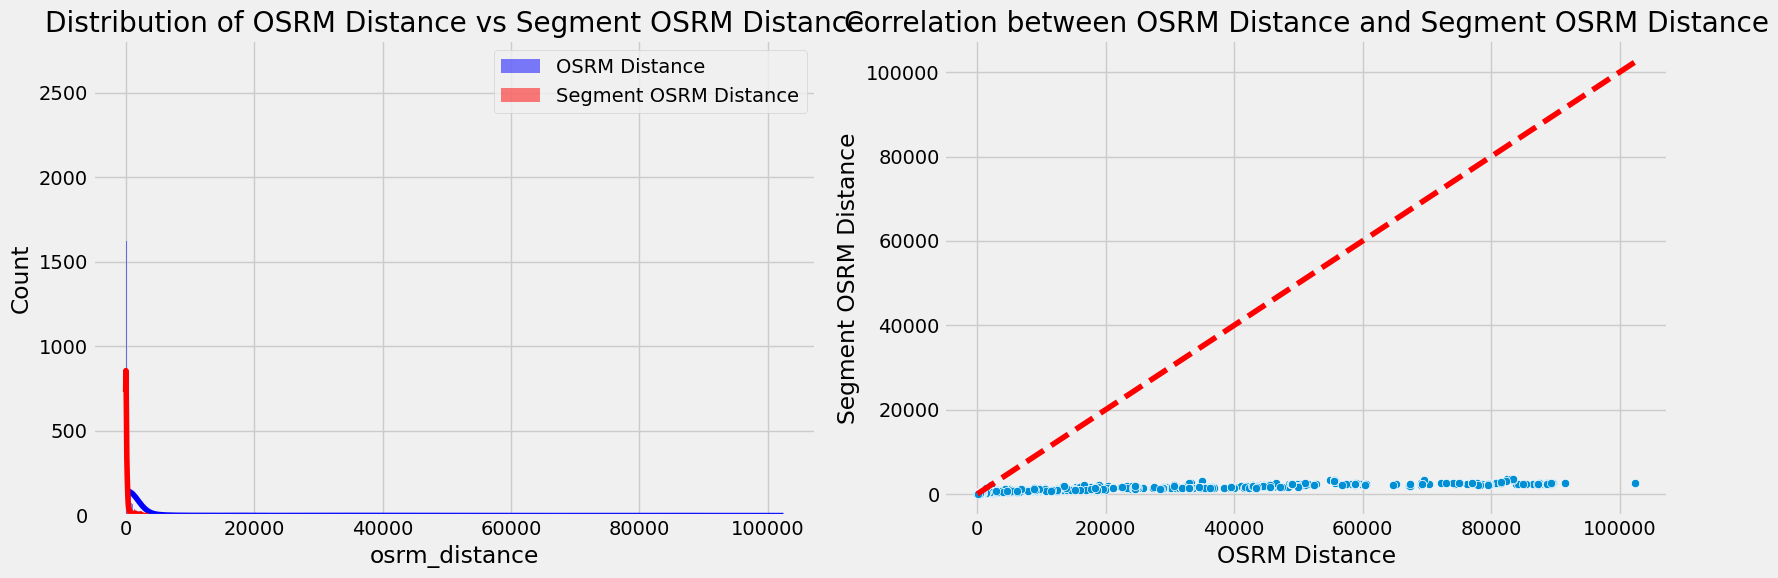

Correlation between OSRM Distance and Segment OSRM Distance: 0.9112

T-test between OSRM Time and Segment OSRM Time:
t-statistic: 30.2974, p-value: 0.00000000
Significant difference found between OSRM Time and Segment OSRM Time


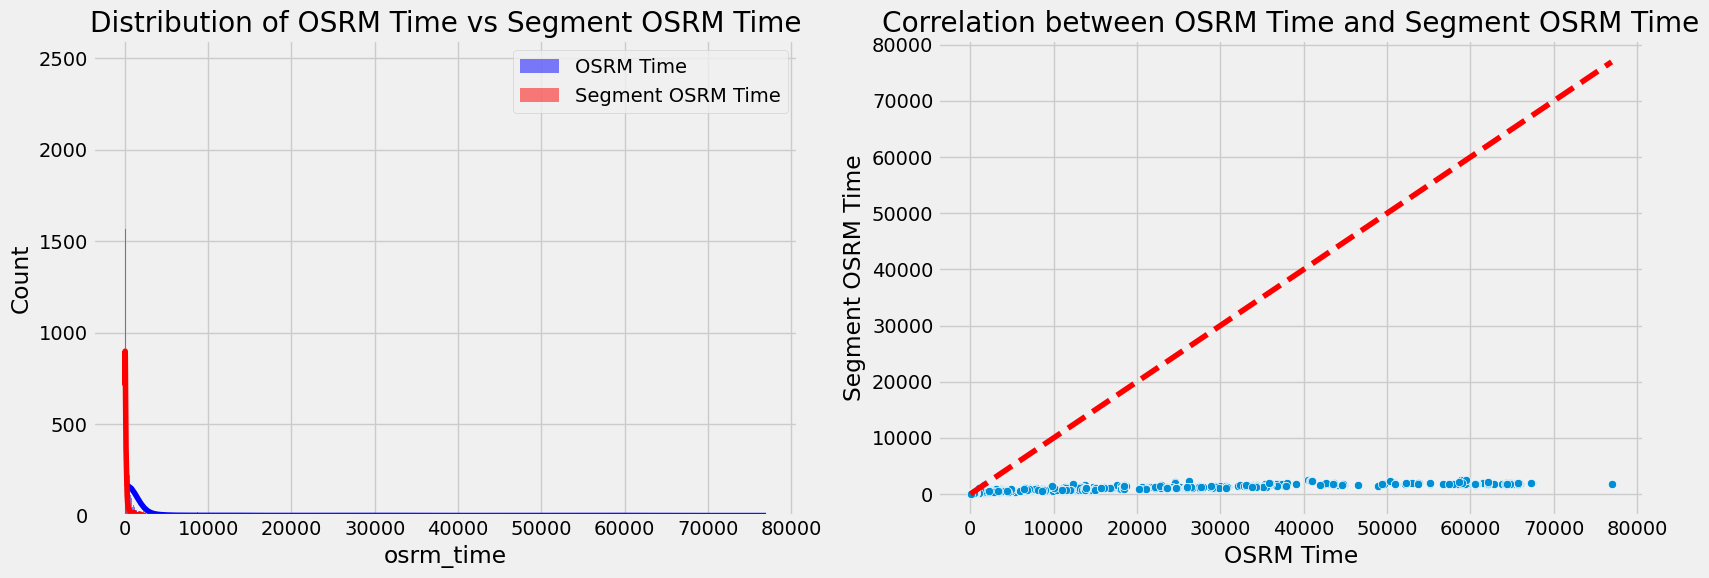

Correlation between OSRM Time and Segment OSRM Time: 0.9032



In [59]:
# Compare actual_time vs osrm_time
if 'actual_time' in trip_df.columns and 'osrm_time' in trip_df.columns:
    compare_metrics(trip_df, 'actual_time', 'osrm_time', 'Actual Time', 'OSRM Time')

# Compare actual_time vs segment_actual_time
if 'actual_time' in trip_df.columns and 'segment_actual_time' in trip_df.columns:
    compare_metrics(trip_df, 'actual_time', 'segment_actual_time', 'Actual Time', 'Segment Actual Time')

# Compare osrm_distance vs segment_osrm_distance
if 'osrm_distance' in trip_df.columns and 'segment_osrm_distance' in trip_df.columns:
    compare_metrics(trip_df, 'osrm_distance', 'segment_osrm_distance', 'OSRM Distance', 'Segment OSRM Distance')

# Compare osrm_time vs segment_osrm_time
if 'osrm_time' in trip_df.columns and 'segment_osrm_time' in trip_df.columns:
    compare_metrics(trip_df, 'osrm_time', 'segment_osrm_time', 'OSRM Time', 'Segment OSRM Time')


## **PART 4: OUTLIER DETECTION AND TREATMENT**

In [60]:
# Check for outliers in numerical variables and treat them
print("\n4.1 Outlier Detection:")
numerical_trip_cols = trip_df.select_dtypes(include=['float64', 'int64']).columns.tolist()


4.1 Outlier Detection:


In [61]:
# Create a copy of the dataframe before outlier treatment for comparison
trip_df_before_outlier = trip_df.copy()

Found 2122 outliers in actual_distance_to_destination
Bounds: Lower=-571.94, Upper=1085.50
Min=9.00, Max=85110.89


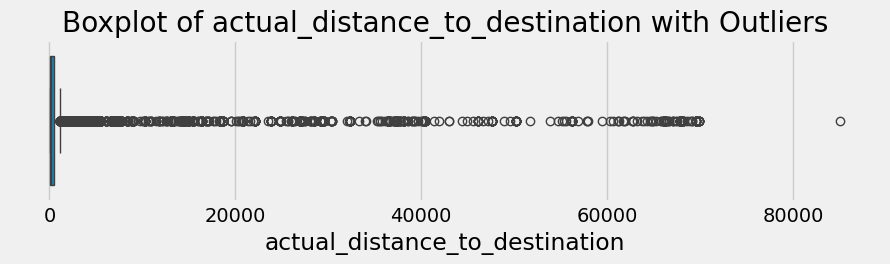

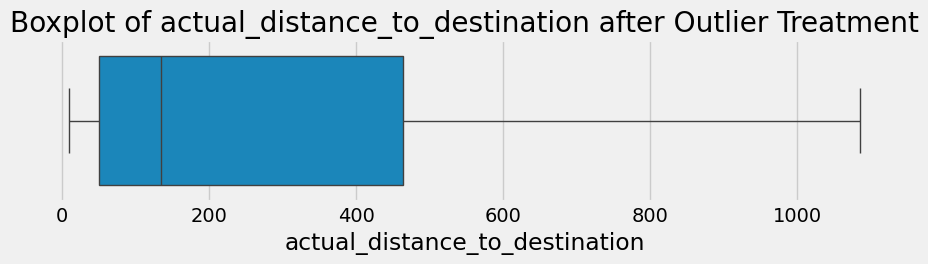

After treatment: Min=9.00, Max=1085.50

Found 2070 outliers in actual_time
Bounds: Lower=-1239.50, Upper=2444.50
Min=9.00, Max=167920.00


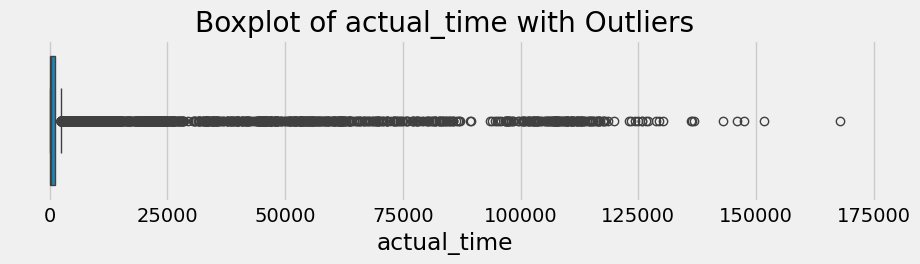

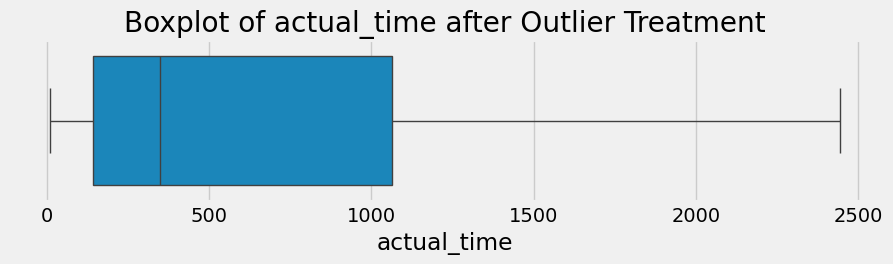

After treatment: Min=9.00, Max=2444.50

Found 1948 outliers in osrm_time
Bounds: Lower=-619.00, Upper=1197.00
Min=6.00, Max=76953.00


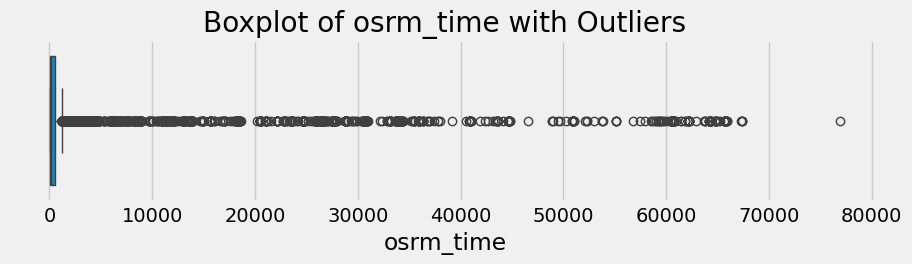

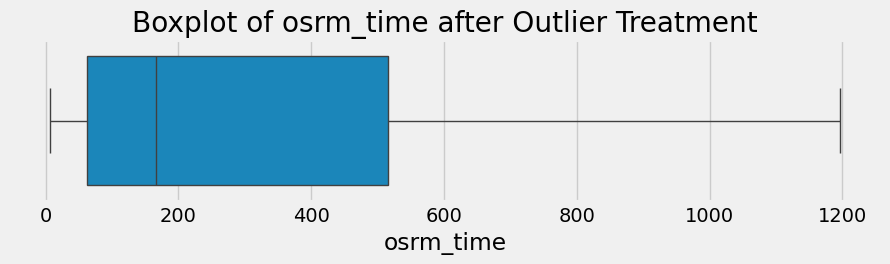

After treatment: Min=6.00, Max=1197.00

Found 2069 outliers in osrm_distance
Bounds: Lower=-747.17, Upper=1420.59
Min=9.07, Max=102415.87


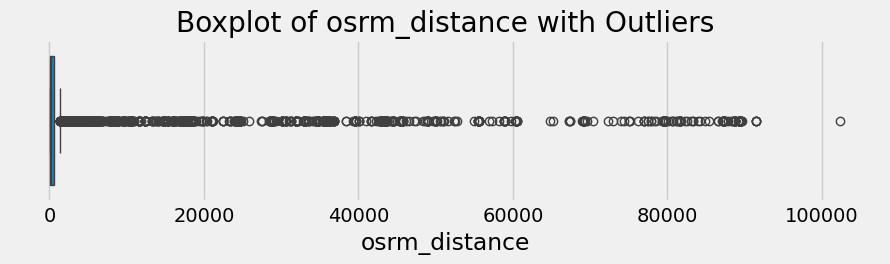

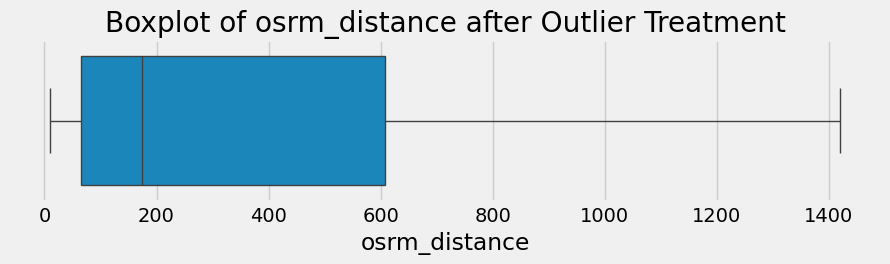

After treatment: Min=9.07, Max=1420.59

Found 1643 outliers in segment_actual_time
Bounds: Lower=-385.50, Upper=818.50
Min=9.00, Max=6230.00


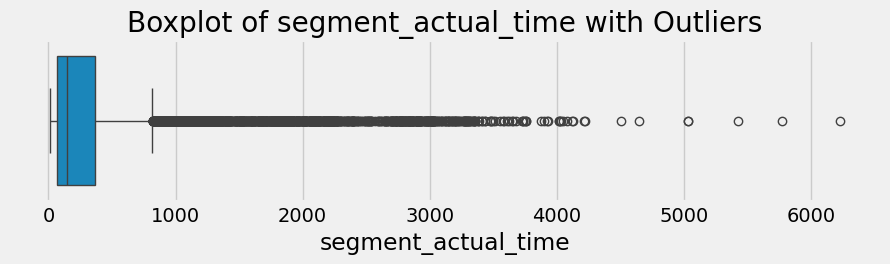

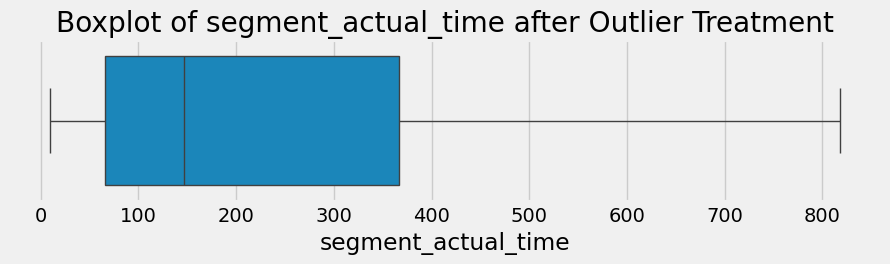

After treatment: Min=9.00, Max=818.50

Found 1492 outliers in segment_osrm_time
Bounds: Lower=-200.00, Upper=416.00
Min=6.00, Max=2564.00


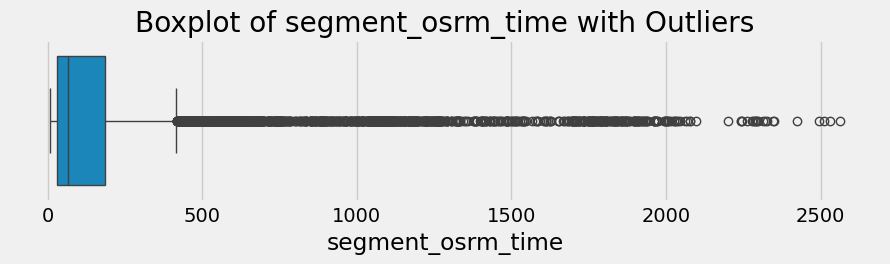

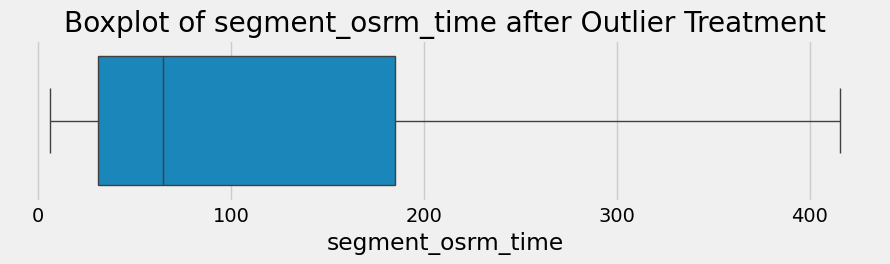

After treatment: Min=6.00, Max=416.00

Found 1548 outliers in segment_osrm_distance
Bounds: Lower=-246.57, Upper=498.02
Min=9.07, Max=3523.63


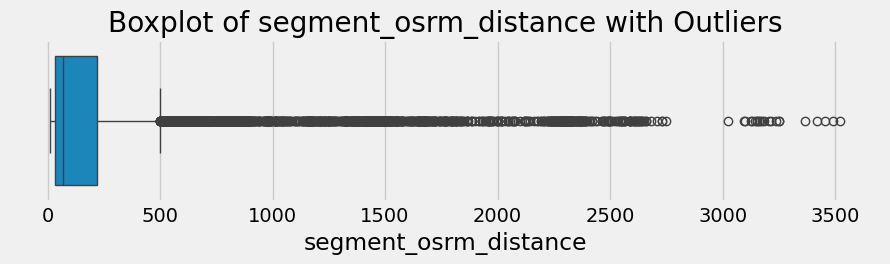

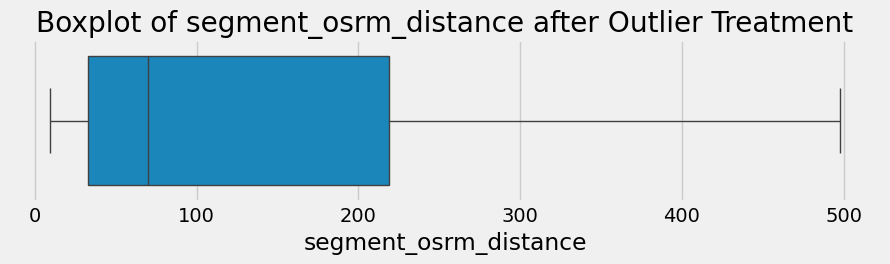

After treatment: Min=9.07, Max=498.02

Found 2023 outliers in od_time_diff_hour
Bounds: Lower=-53.75, Upper=107.79
Min=0.44, Max=6613.91


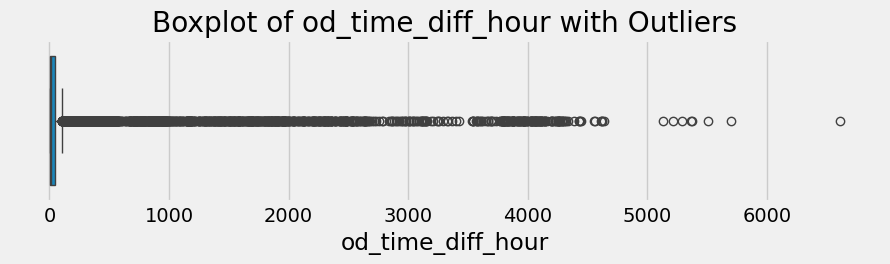

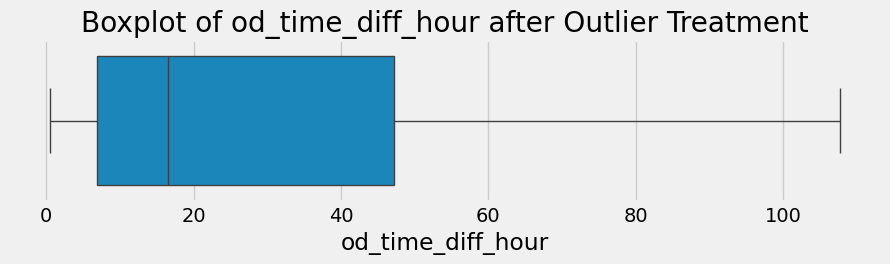

After treatment: Min=0.44, Max=107.79



In [62]:
# Detect and remove outliers for each numerical column
for col in numerical_trip_cols:
    if col in time_distance_cols:  # Apply only to relevant numerical columns
        # Calculate IQR
        Q1 = trip_df[col].quantile(0.25)
        Q3 = trip_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = trip_df[(trip_df[col] < lower_bound) | (trip_df[col] > upper_bound)]
        outlier_count = len(outliers)

        if outlier_count > 0:
            print(f"Found {outlier_count} outliers in {col}")
            print(f"Bounds: Lower={lower_bound:.2f}, Upper={upper_bound:.2f}")
            print(f"Min={trip_df[col].min():.2f}, Max={trip_df[col].max():.2f}")

            # Visualize outliers
            plt.figure(figsize=(10, 2))
            sns.boxplot(x=trip_df[col])
            plt.title(f'Boxplot of {col} with Outliers')
            plt.show()

            # Apply outlier treatment - cap at bounds
            trip_df[col] = trip_df[col].clip(lower=lower_bound, upper=upper_bound)

            # Visualize after treatment
            plt.figure(figsize=(10, 2))
            sns.boxplot(x=trip_df[col])
            plt.title(f'Boxplot of {col} after Outlier Treatment')
            plt.show()

            print(f"After treatment: Min={trip_df[col].min():.2f}, Max={trip_df[col].max():.2f}")
            print()


## **PART 5: FEATURE ENCODING AND NORMALIZATION**

In [63]:
# One-hot encoding for categorical variables
print("\n5.1 One-hot Encoding:")
categorical_cols_to_encode = ['route_type', 'source_state', 'destination_state']



5.1 One-hot Encoding:


In [64]:
print("\nChecking state columns in aggregated dataframe:")
if 'source_state' in trip_df.columns:
    print(f"source_state exists with {trip_df['source_state'].nunique()} unique values")
    print(f"Null values: {trip_df['source_state'].isnull().sum()}/{len(trip_df)}")
    print("Top values:", trip_df['source_state'].value_counts().head(5).to_dict())
else:
    print("source_state column doesn't exist in trip_df")

if 'destination_state' in trip_df.columns:
    print(f"destination_state exists with {trip_df['destination_state'].nunique()} unique values")
    print(f"Null values: {trip_df['destination_state'].isnull().sum()}/{len(trip_df)}")
    print("Top values:", trip_df['destination_state'].value_counts().head(5).to_dict())
else:
    print("destination_state column doesn't exist in trip_df")


Checking state columns in aggregated dataframe:
source_state exists with 29 unique values
Null values: 0/14817
Top values: {'Maharashtra': 2714, 'Karnataka': 2143, 'Haryana': 1854, 'Tamil Nadu': 1039, 'Telangana': 781}
destination_state exists with 31 unique values
Null values: 0/14817
Top values: {'Maharashtra': 2561, 'Karnataka': 2294, 'Haryana': 1670, 'Tamil Nadu': 1084, 'Uttar Pradesh': 811}


In [65]:
# Create dummy variables for each categorical column
for col in categorical_cols_to_encode:
    if col in trip_df.columns:
        # Check if column has more than one unique value
        unique_values = trip_df[col].dropna().unique()
        print(f"Column {col} has {len(unique_values)} unique values: {unique_values}")

        if len(unique_values) > 1:
            # Fill NaN values to avoid issues
            trip_df[col] = trip_df[col].fillna('Unknown')

            # Create dummies
            dummies = pd.get_dummies(trip_df[col], prefix=col, drop_first=True)
            trip_df = pd.concat([trip_df, dummies], axis=1)
            print(f"Created {dummies.shape[1]} dummy variables for {col}")
        else:
            print(f"Skipping one-hot encoding for {col} as it has only {len(unique_values)} unique value(s)")

Column route_type has 2 unique values: ['FTL' 'Carting']
Created 1 dummy variables for route_type
Column source_state has 29 unique values: ['Uttar Pradesh' 'Karnataka' 'Haryana' 'Maharashtra' 'Tamil Nadu'
 'Gujarat' 'Delhi' 'Telangana' 'Rajasthan' 'Assam' 'Madhya Pradesh'
 'West Bengal' 'Andhra Pradesh' 'Punjab' 'Chandigarh' 'Goa' 'Jharkhand'
 'Pondicherry' 'Orissa' 'Uttarakhand' 'Himachal Pradesh' 'Kerala'
 'Arunachal Pradesh' 'Bihar' 'Chhattisgarh' 'Dadra and Nagar Haveli'
 'Jammu & Kashmir' 'Mizoram' 'Nagaland']
Created 28 dummy variables for source_state
Column destination_state has 31 unique values: ['Uttar Pradesh' 'Karnataka' 'Haryana' 'Maharashtra' 'Tamil Nadu'
 'Gujarat' 'Delhi' 'Telangana' 'Rajasthan' 'Madhya Pradesh' 'Assam'
 'West Bengal' 'Andhra Pradesh' 'Punjab' 'Chandigarh'
 'Dadra and Nagar Haveli' 'Orissa' 'Bihar' 'Jharkhand' 'Goa' 'Uttarakhand'
 'Himachal Pradesh' 'Kerala' 'Arunachal Pradesh' 'Mizoram' 'Chhattisgarh'
 'Jammu & Kashmir' 'Nagaland' 'Meghalaya' 'Tripura

In [66]:
# Check extracted state values
if 'source_state' in trip_df.columns:
    print("\nSource state value counts:")
    print(trip_df['source_state'].value_counts().head(10))
    print(f"Null values: {trip_df['source_state'].isnull().sum()}")

if 'destination_state' in trip_df.columns:
    print("\nDestination state value counts:")
    print(trip_df['destination_state'].value_counts().head(10))
    print(f"Null values: {trip_df['destination_state'].isnull().sum()}")


Source state value counts:
source_state
Maharashtra      2714
Karnataka        2143
Haryana          1854
Tamil Nadu       1039
Telangana         781
Uttar Pradesh     762
Gujarat           750
Delhi             728
West Bengal       665
Punjab            536
Name: count, dtype: int64
Null values: 0

Destination state value counts:
destination_state
Maharashtra      2561
Karnataka        2294
Haryana          1670
Tamil Nadu       1084
Uttar Pradesh     811
Telangana         784
Gujarat           734
West Bengal       697
Delhi             652
Punjab            617
Name: count, dtype: int64
Null values: 0


In [67]:
# Normalize/Standardize numerical features
print("\n5.2 Normalization/Standardization:")
numerical_cols_to_normalize = ['actual_distance_to_destination', 'actual_time', 'osrm_time',
                              'osrm_distance', 'segment_actual_time', 'segment_osrm_time',
                              'segment_osrm_distance', 'od_time_diff_hour']



5.2 Normalization/Standardization:


In [68]:
# Apply Min-Max Scaling
scaler = MinMaxScaler()

In [69]:
# Store original values for comparison
trip_df_original = trip_df.copy()

Applied Min-Max scaling to 8 columns


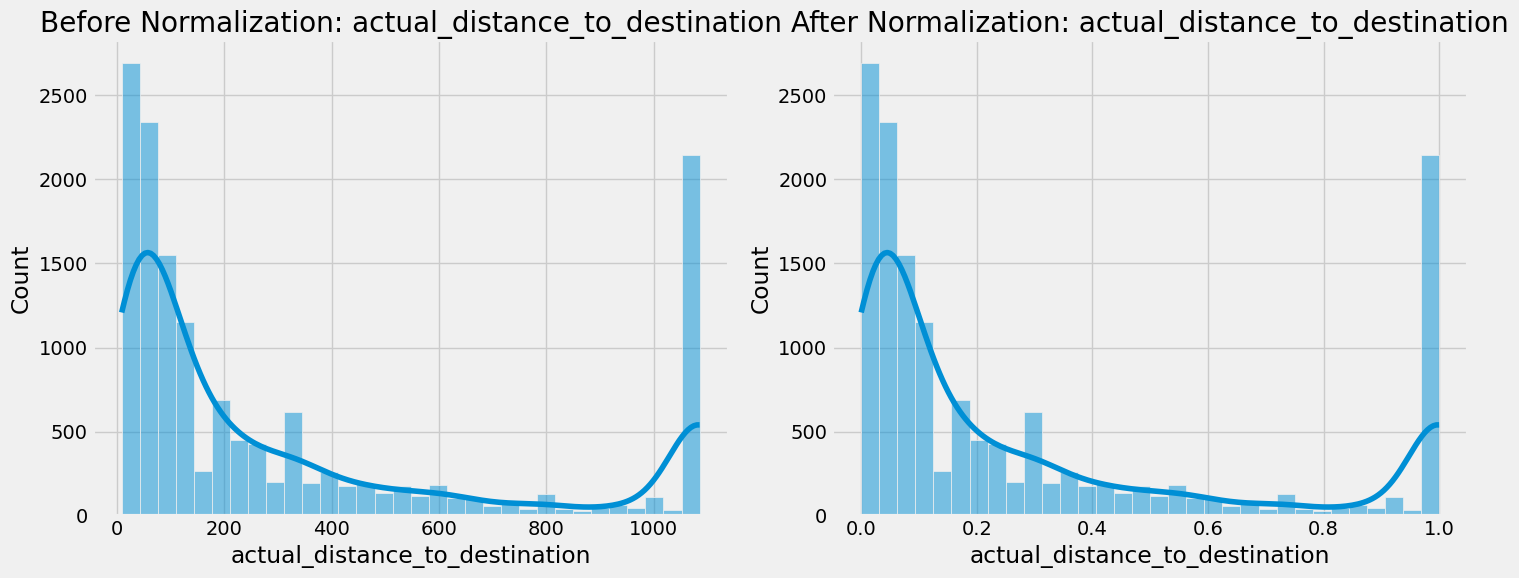

In [70]:
# Apply scaling only to columns that exist in the dataframe
cols_to_scale = [col for col in numerical_cols_to_normalize if col in trip_df.columns]
if cols_to_scale:
    trip_df[cols_to_scale] = scaler.fit_transform(trip_df[cols_to_scale])
    print(f"Applied Min-Max scaling to {len(cols_to_scale)} columns")

    # Visualize before and after normalization for the first column
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(trip_df_original[cols_to_scale[0]], kde=True)
    plt.title(f"Before Normalization: {cols_to_scale[0]}")

    plt.subplot(1, 2, 2)
    sns.histplot(trip_df[cols_to_scale[0]], kde=True)
    plt.title(f"After Normalization: {cols_to_scale[0]}")
    plt.tight_layout()
    plt.show()

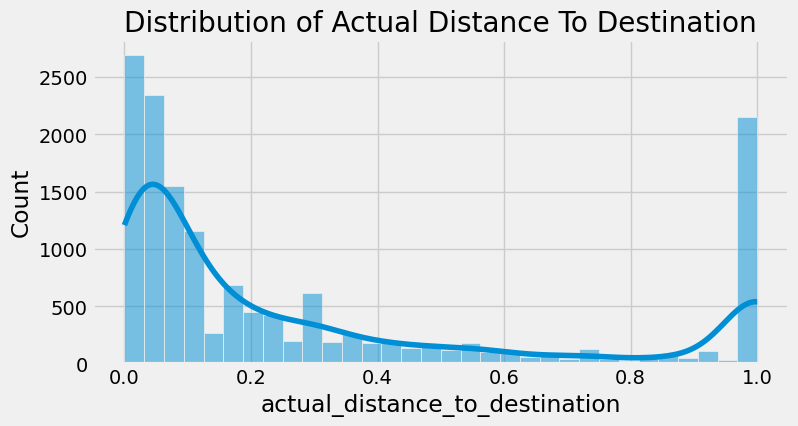

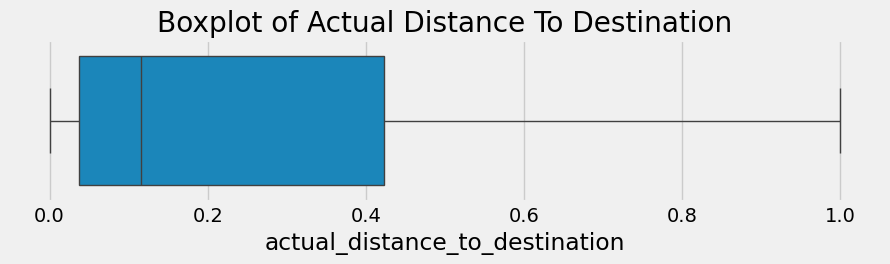

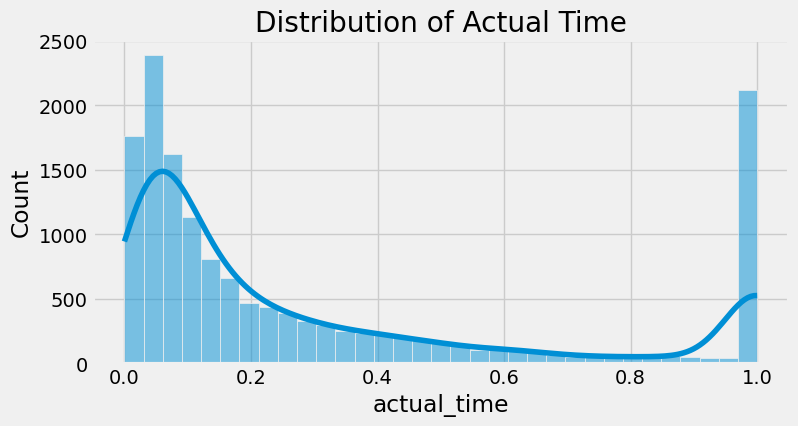

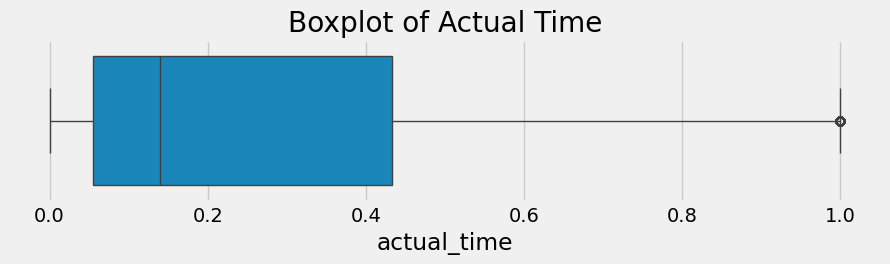

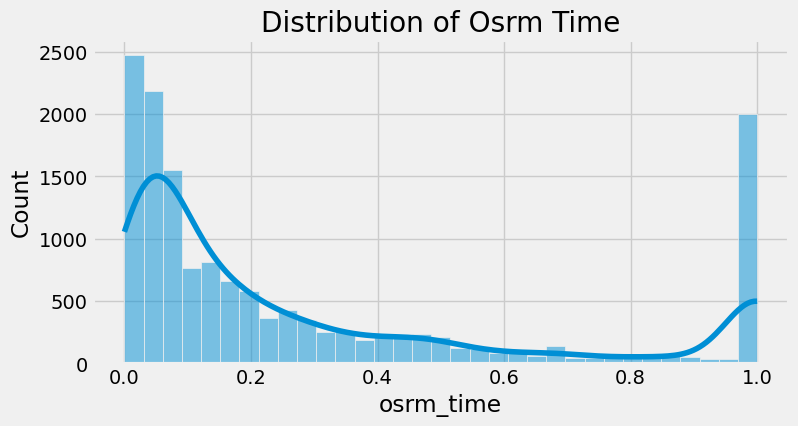

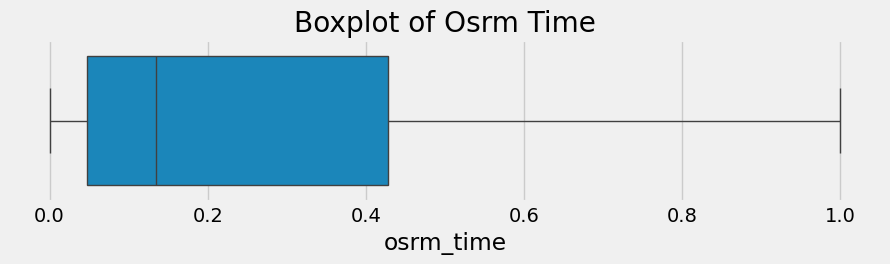

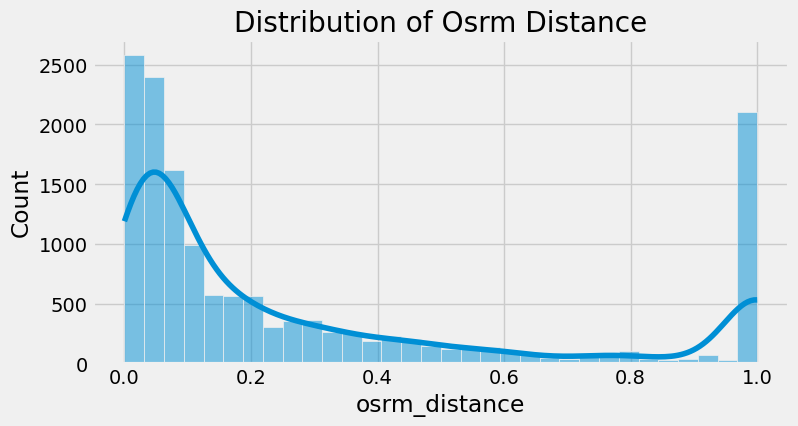

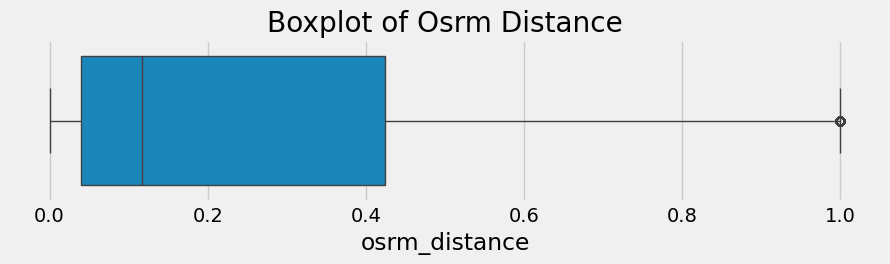

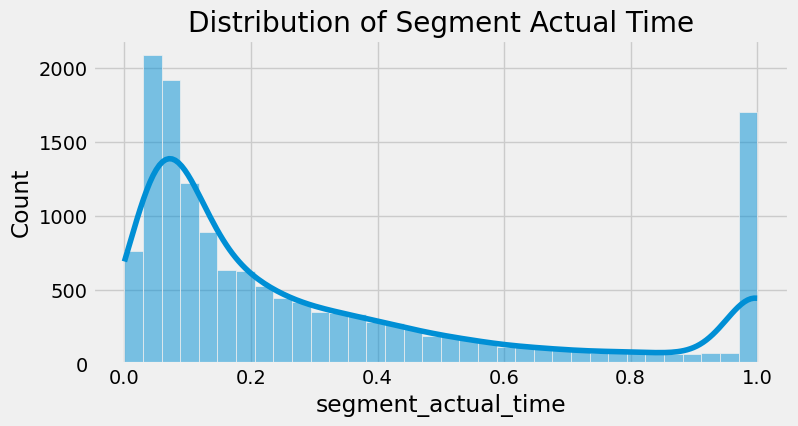

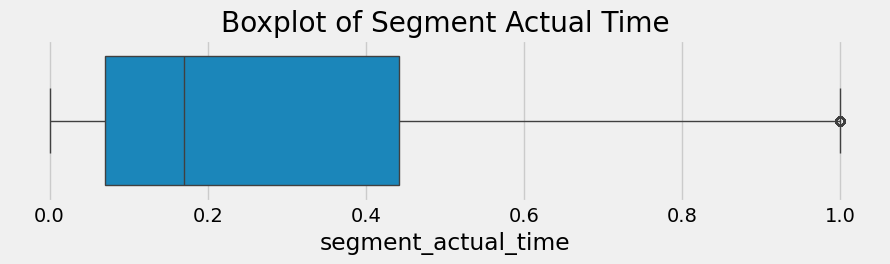

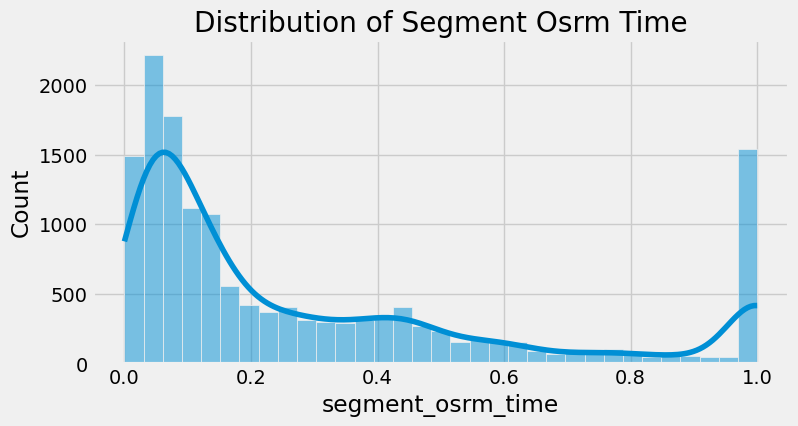

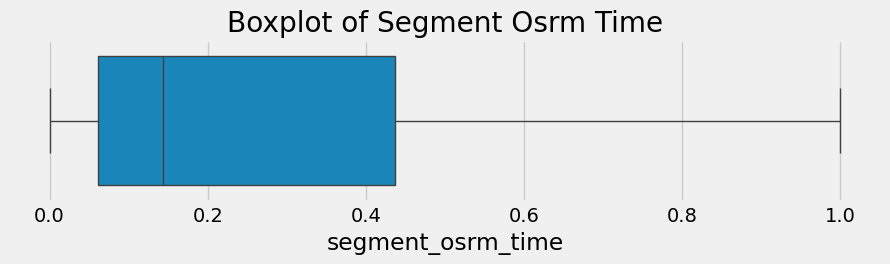

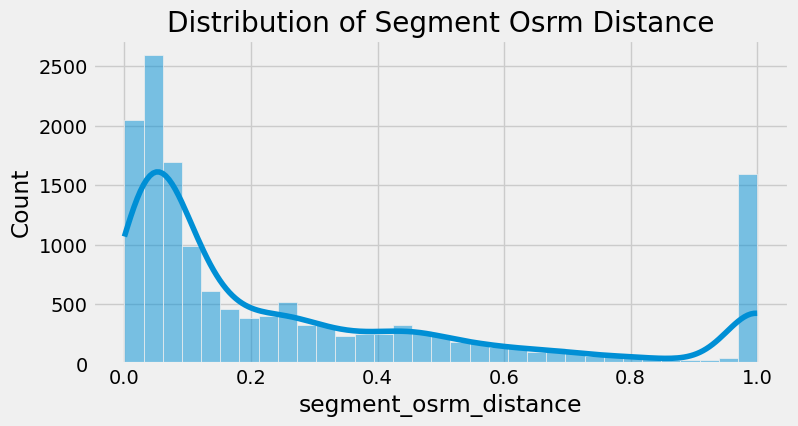

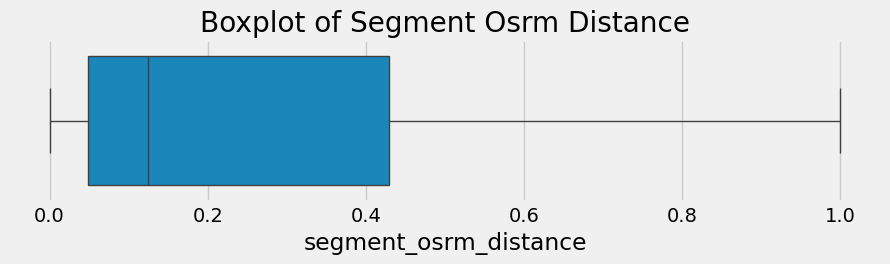

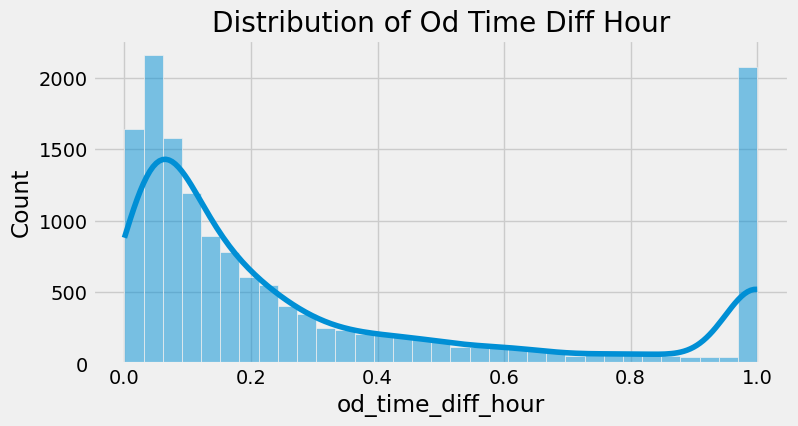

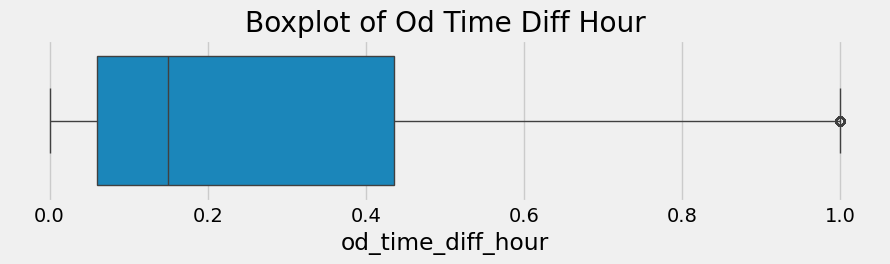

In [71]:
# Distribution of Time and Distance Post Normalization

for col in time_distance_cols:
    if col in trip_df.columns:
        plot_distribution(trip_df, col, col.replace('_', ' ').title())

T-test between Actual Time and OSRM Time:
t-statistic: 12.7987, p-value: 0.00000000
Significant difference found between Actual Time and OSRM Time


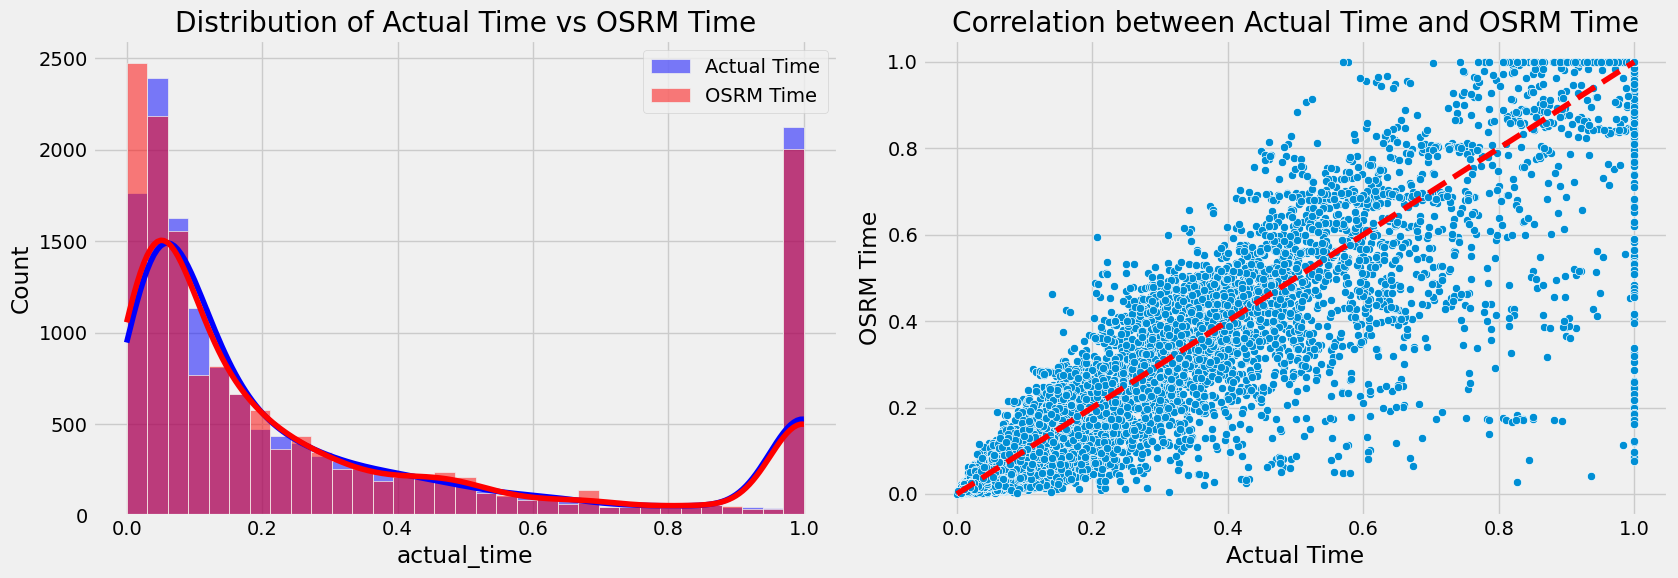

Correlation between Actual Time and OSRM Time: 0.9593

T-test between Actual Time and Segment Actual Time:
t-statistic: -7.9645, p-value: 0.00000000
Significant difference found between Actual Time and Segment Actual Time


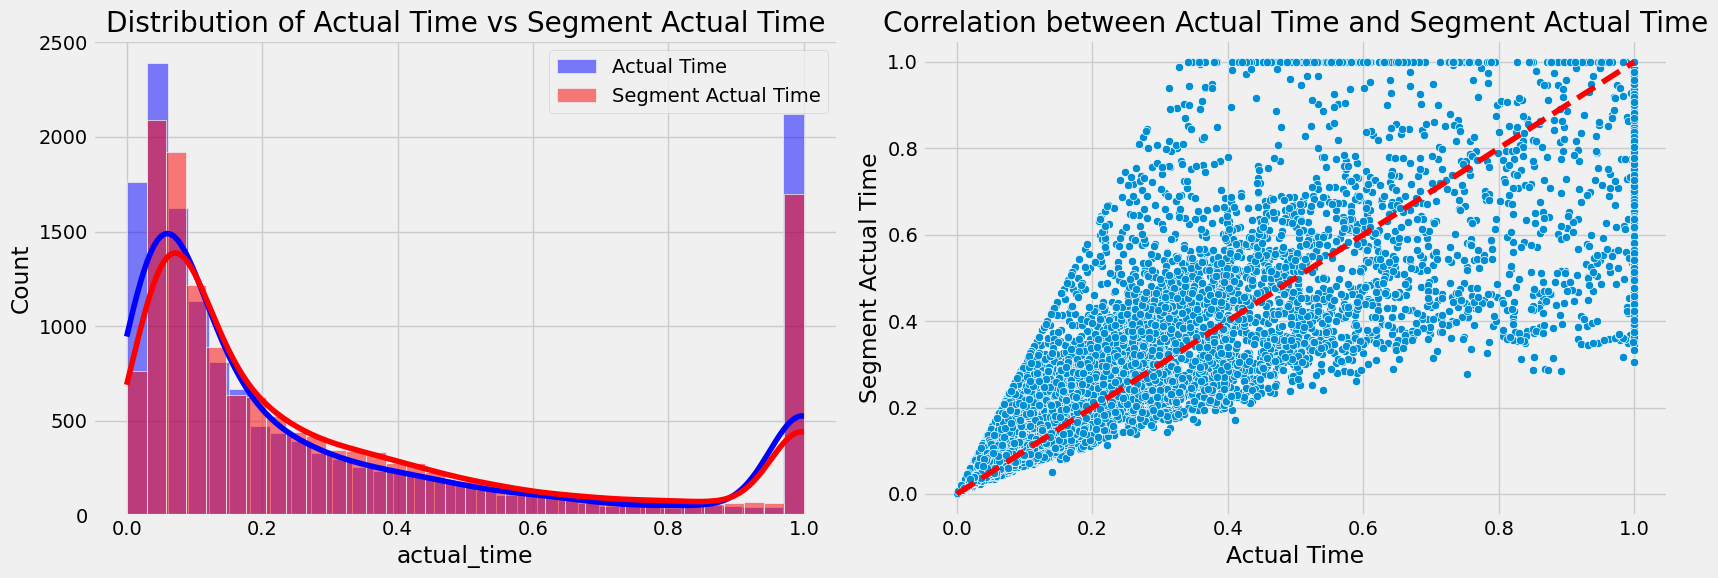

Correlation between Actual Time and Segment Actual Time: 0.9285

T-test between OSRM Distance and Segment OSRM Distance:
t-statistic: 10.1624, p-value: 0.00000000
Significant difference found between OSRM Distance and Segment OSRM Distance


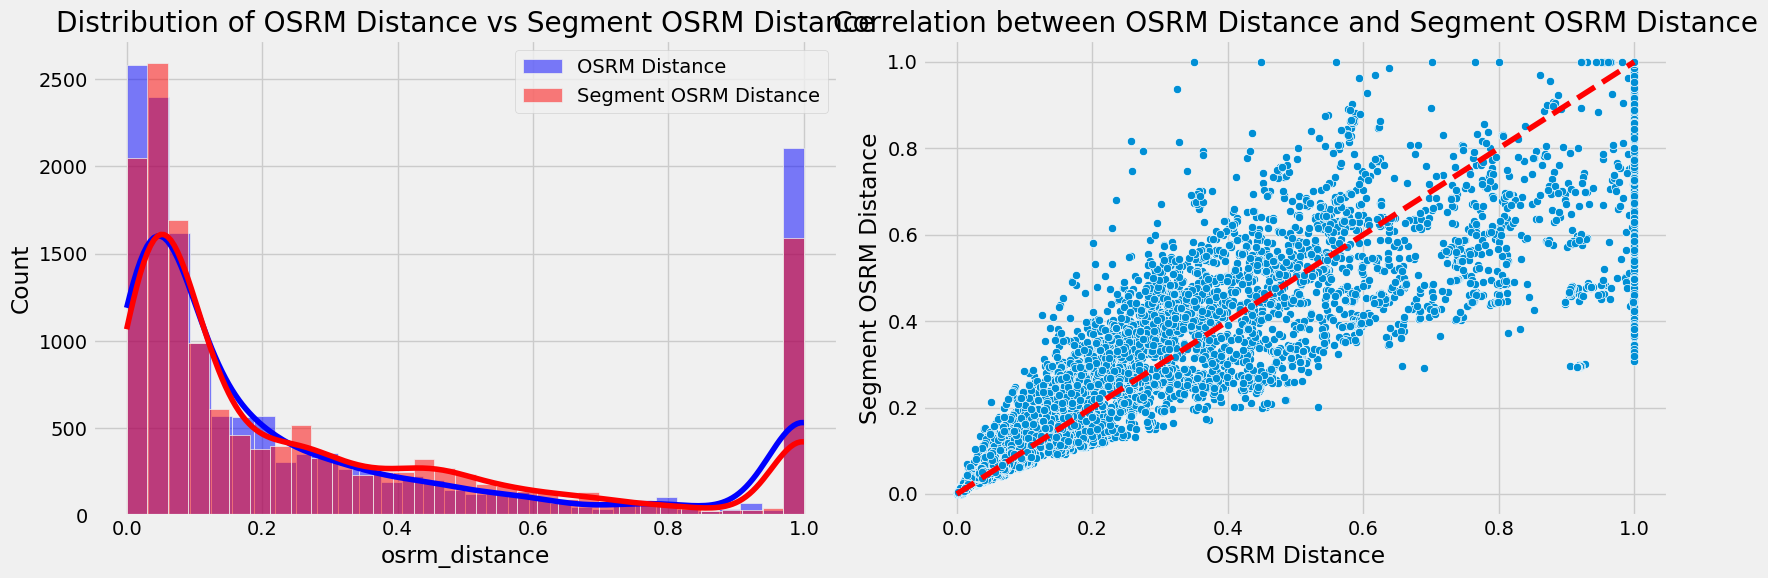

Correlation between OSRM Distance and Segment OSRM Distance: 0.9514

T-test between OSRM Time and Segment OSRM Time:
t-statistic: 0.7053, p-value: 0.48064709
No significant difference found between OSRM Time and Segment OSRM Time


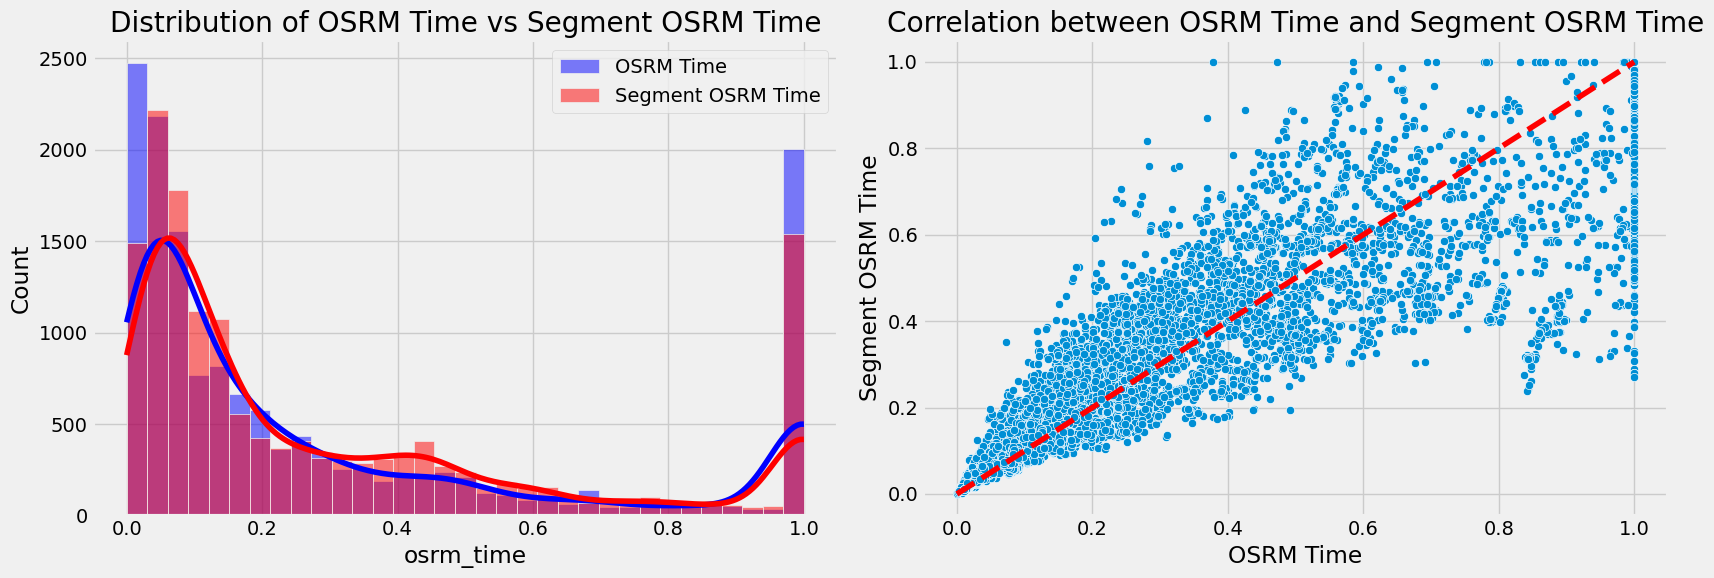

Correlation between OSRM Time and Segment OSRM Time: 0.9486



In [72]:
# Hypothesis Testing Post Normalization

# Compare actual_time vs osrm_time
if 'actual_time' in trip_df.columns and 'osrm_time' in trip_df.columns:
    compare_metrics(trip_df, 'actual_time', 'osrm_time', 'Actual Time', 'OSRM Time')

# Compare actual_time vs segment_actual_time
if 'actual_time' in trip_df.columns and 'segment_actual_time' in trip_df.columns:
    compare_metrics(trip_df, 'actual_time', 'segment_actual_time', 'Actual Time', 'Segment Actual Time')

# Compare osrm_distance vs segment_osrm_distance
if 'osrm_distance' in trip_df.columns and 'segment_osrm_distance' in trip_df.columns:
    compare_metrics(trip_df, 'osrm_distance', 'segment_osrm_distance', 'OSRM Distance', 'Segment OSRM Distance')

# Compare osrm_time vs segment_osrm_time
if 'osrm_time' in trip_df.columns and 'segment_osrm_time' in trip_df.columns:
    compare_metrics(trip_df, 'osrm_time', 'segment_osrm_time', 'OSRM Time', 'Segment OSRM Time')


## **PART 6: BUSINESS INSIGHTS**

In [73]:
# Analyze business patterns
print("\n6.0 Top Source and Destination Analysis:")


6.0 Top Source and Destination Analysis:


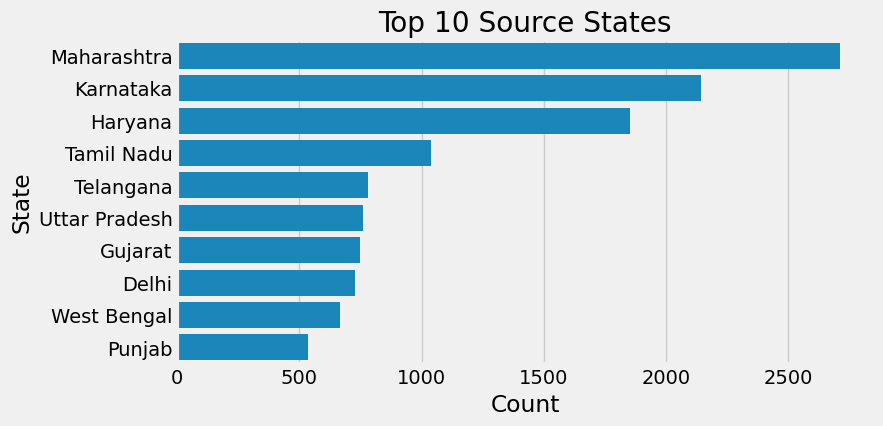

Top 5 Source States:


State  Count
0  Maharashtra   2714
1    Karnataka   2143
2      Haryana   1854
3   Tamil Nadu   1039
4    Telangana    781

In [74]:
# Top source states
if 'source_state' in trip_df.columns:
    state_counts = trip_df['source_state'].value_counts().reset_index()
    state_counts.columns = ['State', 'Count']

    plt.figure(figsize=(8, 4))
    sns.barplot(x='Count', y='State', data=state_counts.head(10))
    plt.title('Top 10 Source States')
    plt.show()

print("Top 5 Source States:")
state_counts.head(5)

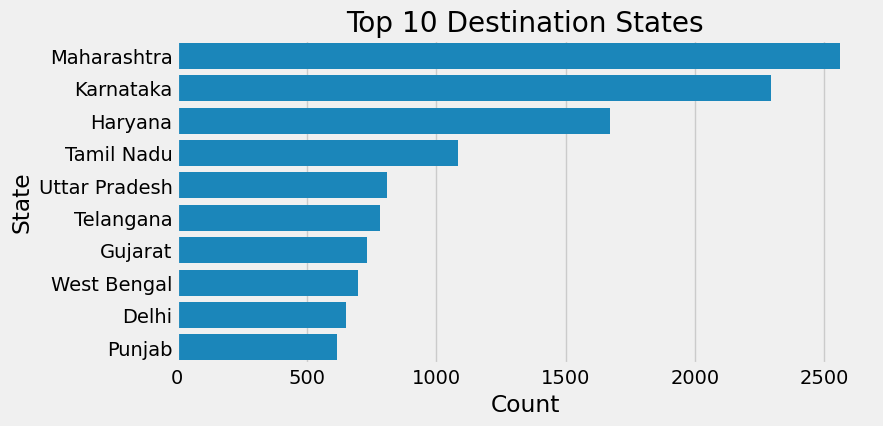


Top 5 Destination States:


State  Count
0    Maharashtra   2561
1      Karnataka   2294
2        Haryana   1670
3     Tamil Nadu   1084
4  Uttar Pradesh    811

In [75]:
# Top destination states
if 'destination_state' in trip_df.columns:
    state_counts = trip_df['destination_state'].value_counts().reset_index()
    state_counts.columns = ['State', 'Count']

    plt.figure(figsize=(8, 4))
    sns.barplot(x='Count', y='State', data=state_counts.head(10))
    plt.title('Top 10 Destination States')
    plt.show()

print("\nTop 5 Destination States:")
state_counts.head(5)

In [76]:
# Create corridor feature
trip_df['corridor'] = trip_df['source_state'] + ' to ' + trip_df['destination_state']

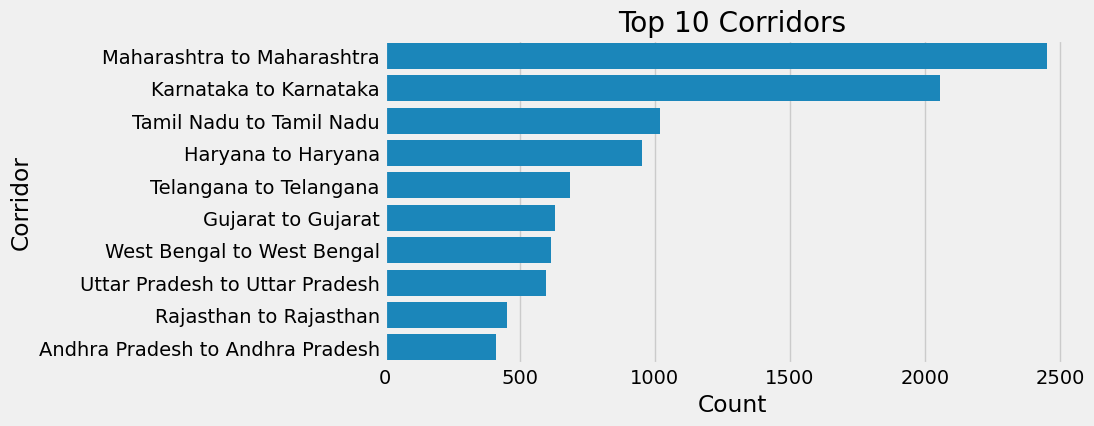

Top 5 Corridors:


Corridor  Count
0  Maharashtra to Maharashtra   2453
1      Karnataka to Karnataka   2056
2    Tamil Nadu to Tamil Nadu   1021
3          Haryana to Haryana    953
4      Telangana to Telangana    685

In [77]:
# Get top corridors
corridor_counts = trip_df['corridor'].value_counts().reset_index()
corridor_counts.columns = ['Corridor', 'Count']

plt.figure(figsize=(8, 4))
sns.barplot(x='Count', y='Corridor', data=corridor_counts.head(10))
plt.title('Top 10 Corridors')
plt.show()

print("Top 5 Corridors:")
corridor_counts.head(5)

In [78]:
# Merge variance metrics with trip_df
trip_df = pd.merge(trip_df, variance_metrics, on='trip_uuid', how='left')
print(f"Added variance metrics to trip dataframe. New shape: {trip_df.shape}")

Added variance metrics to trip dataframe. New shape: (14817, 121)


In [79]:
# 6.1 Route Performance Analysis
print("\n6.1 Route Performance Analysis:")


6.1 Route Performance Analysis:


In [80]:
# Analyze routes with highest delay percentages
route_delay_analysis = trip_df.groupby('corridor').agg({
    'delay_time_pct': 'mean',
    'trip_uuid': 'count',
    'actual_distance_to_destination': 'mean',
    'actual_time': 'mean',
    'osrm_time': 'mean'
}).reset_index()

route_delay_analysis = route_delay_analysis.rename(columns={'trip_uuid': 'trip_count'})
route_delay_analysis = route_delay_analysis.sort_values('delay_time_pct', ascending=False)

In [81]:
# Filter to routes with at least 5 trips for reliability
route_delay_analysis_filtered = route_delay_analysis[route_delay_analysis['trip_count'] >= 5]

print("Top 10 Routes with Highest Delay Percentages (minimum 5 trips):")
route_delay_analysis_filtered.head(10)[['corridor', 'delay_time_pct', 'trip_count', 'actual_time', 'osrm_time']]

Top 10 Routes with Highest Delay Percentages (minimum 5 trips):


corridor  delay_time_pct  trip_count  \
94                      Nagaland to Assam          414.85           5   
132                Uttarakhand to Haryana          305.21          13   
58     Jammu & Kashmir to Jammu & Kashmir          260.68          15   
140            West Bengal to West Bengal          243.36         615   
56   Himachal Pradesh to Himachal Pradesh          238.75          20   
126                Uttar Pradesh to Delhi          237.77          71   
7                          Assam to Assam          233.50         213   
130        Uttar Pradesh to Uttar Pradesh          220.71         597   
77       Madhya Pradesh to Madhya Pradesh          212.70         271   
54                 Haryana to Uttarakhand          208.95          20   

     actual_time  osrm_time  
94          0.51       0.28  
132         0.95       0.87  
58          0.24       0.19  
140         0.25       0.20  
56          0.74       0.44  
126         0.28       0.27  
7           0.39       0.34  
130         0.35       0.29  
77          0.38       0.36  
54          0.78       0.79

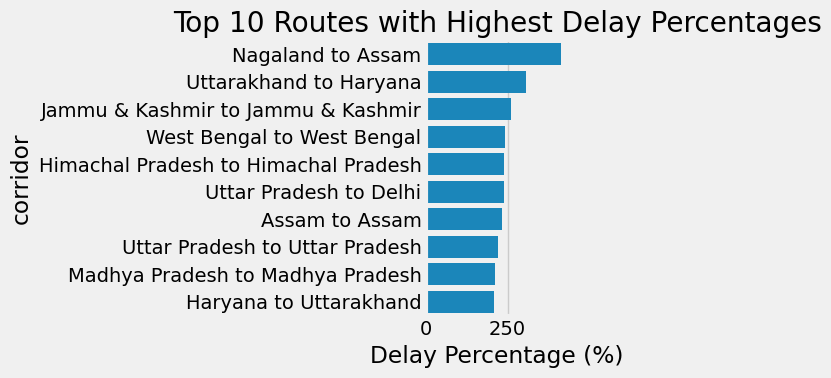

In [82]:
# Visualize top 10 routes with highest delays
plt.figure(figsize=(6, 4))
top_10_delay_routes = route_delay_analysis_filtered.head(10)
sns.barplot(x='delay_time_pct', y='corridor', data=top_10_delay_routes)
plt.title('Top 10 Routes with Highest Delay Percentages')
plt.xlabel('Delay Percentage (%)')
plt.tight_layout()
plt.show()

In [83]:
# 6.2 Network Bottleneck Analysis
print("\n6.2 Network Bottleneck Analysis:")


6.2 Network Bottleneck Analysis:


In [84]:
# Identify bottlenecks by analyzing segment performance
segment_bottleneck = segment_df.groupby(['source_city', 'destination_city']).agg({
    'segment_delay_time_pct': 'mean',
    'segment_key': 'count',
    'segment_actual_time': 'mean',
    'segment_osrm_time': 'mean',
    'segment_actual_speed': 'mean'
}).reset_index()

segment_bottleneck = segment_bottleneck.rename(columns={'segment_key': 'segment_count'})
segment_bottleneck = segment_bottleneck.sort_values('segment_delay_time_pct', ascending=False)

In [85]:
# Filter to segments with at least 5 occurrences
segment_bottleneck_filtered = segment_bottleneck[segment_bottleneck['segment_count'] >= 5]

print("Top 10 Segment Bottlenecks (minimum 5 segments):")
segment_bottleneck_filtered.head(10)[['source_city', 'destination_city', 'segment_delay_time_pct',
                                           'segment_count', 'segment_actual_time', 'segment_osrm_time']]

Top 10 Segment Bottlenecks (minimum 5 segments):


source_city destination_city  segment_delay_time_pct  segment_count  \
943        Hubli          Dharwad       42055555558450.44              9   
1053    Jangipur       Sagardighi        3602941176533.27             17   
1829      Purnia          Katihar        3000000000626.06             13   
45     Allahabad        Allahabad        2771604938889.91             27   
1290     Kolkata       Tarkeshwar        2444444444845.97              9   
1666       Noida            Noida        1846153846266.68             39   
754          Goa              Goa        1738095238300.05             21   
2322  Villupuram              MAA        1357142857197.32              6   
1969  Samastipur    HazratJandaha        1218750000252.71             16   
15     Ahmedabad          Amdavad        1176470588457.32             34   

      segment_actual_time  segment_osrm_time  
943                213.11              21.11  
1053                75.47              43.35  
1829                73.62              19.23  
45                 139.93              11.11  
1290               184.22              42.89  
1666                43.44              17.31  
754                102.29              27.29  
2322               214.00             126.83  
1969                62.56              18.38  
15                  48.47              16.00

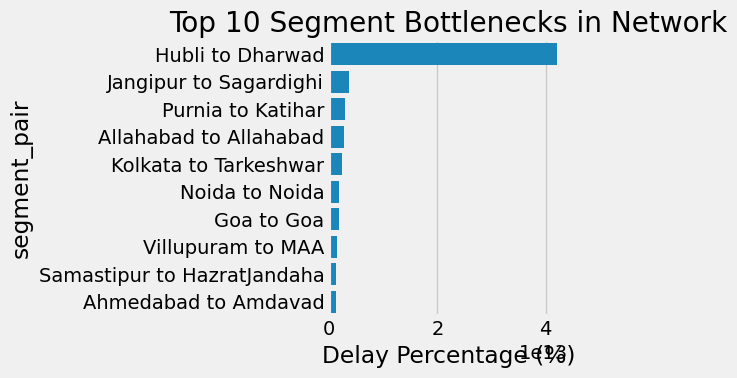

In [86]:
# Visualize top bottlenecks
plt.figure(figsize=(6, 4))
top_10_bottlenecks = segment_bottleneck_filtered.head(10)
top_10_bottlenecks['segment_pair'] = top_10_bottlenecks['source_city'] + ' to ' + top_10_bottlenecks['destination_city']
sns.barplot(x='segment_delay_time_pct', y='segment_pair', data=top_10_bottlenecks)
plt.title('Top 10 Segment Bottlenecks in Network')
plt.xlabel('Delay Percentage (%)')
plt.tight_layout()
plt.show()

In [87]:
# 6.3 Efficiency Analysis by Route Type and Geography
print("\n6.3 Efficiency Analysis by Route Type and Geography:")


6.3 Efficiency Analysis by Route Type and Geography:


In [88]:
# Compare efficiency across route types
route_type_efficiency = trip_df.groupby('route_type').agg({
    'actual_speed': 'mean',
    'delay_time_pct': 'mean',
    'time_efficiency_ratio': 'mean',
    'trip_uuid': 'count',
    'actual_distance_to_destination': 'mean'
}).reset_index()

route_type_efficiency = route_type_efficiency.rename(columns={'trip_uuid': 'trip_count'})

print("Efficiency Metrics by Route Type:")
route_type_efficiency

Efficiency Metrics by Route Type:


route_type  actual_speed  delay_time_pct  time_efficiency_ratio  trip_count  \
0    Carting          0.43          162.00                   4.37        8908   
1        FTL          0.56          115.44                   3.60        5909   

   actual_distance_to_destination  
0                            0.11  
1                            0.57

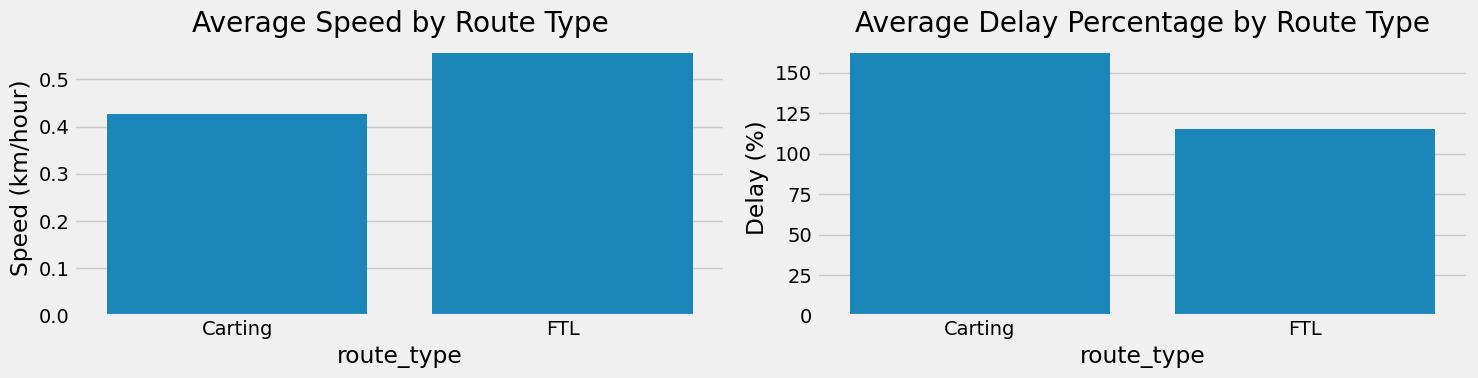

In [89]:
# Visualize efficiency by route type
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
sns.barplot(x='route_type', y='actual_speed', data=route_type_efficiency)
plt.title('Average Speed by Route Type')
plt.ylabel('Speed (km/hour)')

plt.subplot(1, 2, 2)
sns.barplot(x='route_type', y='delay_time_pct', data=route_type_efficiency)
plt.title('Average Delay Percentage by Route Type')
plt.ylabel('Delay (%)')
plt.tight_layout()
plt.show()


Efficiency Metrics by Regional Corridor (minimum 5 trips):


region_corridor  actual_speed  delay_time_pct  time_efficiency_ratio  \
14      South to South          0.49          107.00                   4.14   
20        West to West          0.44          181.45                   3.82   
8       North to North          0.50          127.79                   4.39   
3         East to East          0.39          220.06                   3.31   
0   Central to Central          0.47          195.99                   3.04   
10       North to West          0.58           86.81                   4.06   
18       West to North          0.63           87.57                   5.32   
19       West to South          0.62           75.75                   4.44   
9       North to South          0.61           78.57                   5.06   
7        North to East          0.60          114.58                   5.22   

    trip_count  actual_distance_to_destination  
14        4603                            0.21  
20        3672                            0.23  
8         3527                            0.29  
3         1343                            0.29  
0          317                            0.36  
10         195                            0.87  
18         154                            0.93  
19         145                            0.95  
9          127                            0.97  
7          103                            0.99

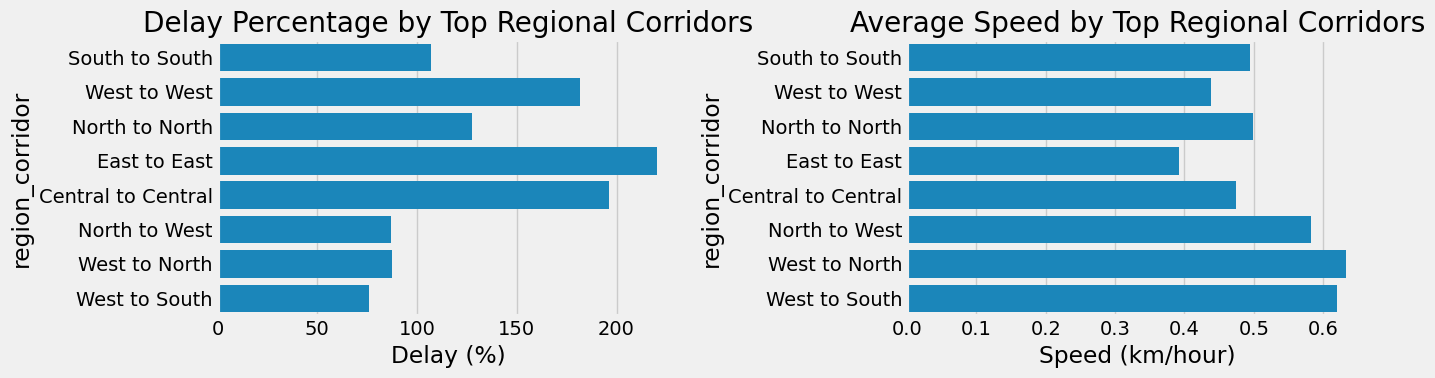

In [90]:
# Regional efficiency analysis
if 'region_corridor' in trip_df.columns:
    region_efficiency = trip_df.groupby('region_corridor').agg({
        'actual_speed': 'mean',
        'delay_time_pct': 'mean',
        'time_efficiency_ratio': 'mean',
        'trip_uuid': 'count',
        'actual_distance_to_destination': 'mean'
    }).reset_index()

    region_efficiency = region_efficiency.rename(columns={'trip_uuid': 'trip_count'})
    region_efficiency = region_efficiency.sort_values('trip_count', ascending=False)

    # Filter to corridors with at least 5 trips
    region_efficiency_filtered = region_efficiency[region_efficiency['trip_count'] >= 5]

    print("\nEfficiency Metrics by Regional Corridor (minimum 5 trips):")
    display(region_efficiency_filtered.head(10))

    # Visualize efficiency by top regional corridors
    plt.figure(figsize=(14, 4))
    top_corridors = region_efficiency_filtered.head(8)

    plt.subplot(1, 2, 1)
    sns.barplot(x='delay_time_pct', y='region_corridor', data=top_corridors)
    plt.title('Delay Percentage by Top Regional Corridors')
    plt.xlabel('Delay (%)')

    plt.subplot(1, 2, 2)
    sns.barplot(x='actual_speed', y='region_corridor', data=top_corridors)
    plt.title('Average Speed by Top Regional Corridors')
    plt.xlabel('Speed (km/hour)')
    plt.tight_layout()
    plt.show()


In [91]:
# 6.4 Time of Day Performance Analysis
print("\n6.4 Time of Day Performance Analysis:")


6.4 Time of Day Performance Analysis:


Performance Metrics by Time of Day:


start_time_of_day  actual_speed  delay_time_pct  trip_count
0             Night          0.47          156.86        6376
1           Morning          0.46          157.15        2451
2         Afternoon          0.48          135.15        2663
3           Evening          0.51          114.23        3327

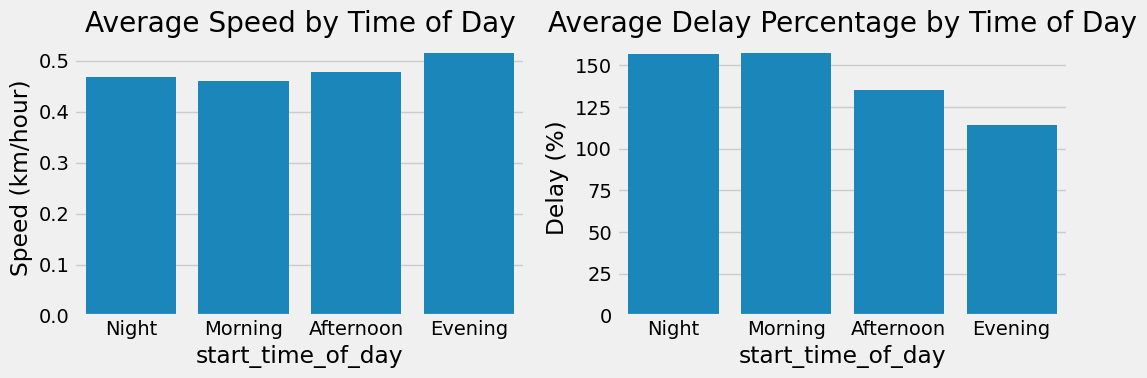

In [92]:
# Analyze performance by time of day
if 'start_time_of_day' in trip_df.columns:
    time_performance = trip_df.groupby('start_time_of_day').agg({
        'actual_speed': 'mean',
        'delay_time_pct': 'mean',
        'trip_uuid': 'count'
    }).reset_index()

    time_performance = time_performance.rename(columns={'trip_uuid': 'trip_count'})

    print("Performance Metrics by Time of Day:")
    display(time_performance)

    # Visualize time of day performance
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    sns.barplot(x='start_time_of_day', y='actual_speed', data=time_performance)
    plt.title('Average Speed by Time of Day')
    plt.ylabel('Speed (km/hour)')

    plt.subplot(1, 2, 2)
    sns.barplot(x='start_time_of_day', y='delay_time_pct', data=time_performance)
    plt.title('Average Delay Percentage by Time of Day')
    plt.ylabel('Delay (%)')
    plt.tight_layout()
    plt.show()

In [93]:
# 6.5 Performance Consistency Analysis
print("\n6.5 Performance Consistency Analysis:")


6.5 Performance Consistency Analysis:


Trip Performance Consistency Distribution:
         Consistency  Count
0  Very Inconsistent   2519
1         Consistent   1476
2       Inconsistent   1321
3    Very Consistent    539


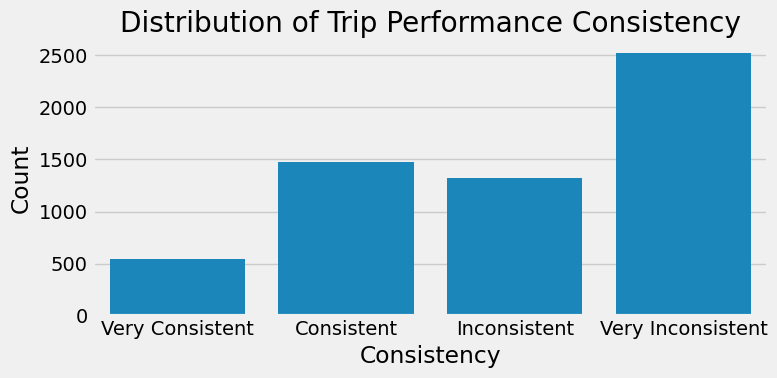


Routes with Most Inconsistent Performance:
                            corridor  inconsistent_trip_count  \
53        Maharashtra to Maharashtra                      377   
78    Uttar Pradesh to Uttar Pradesh                      322   
41            Karnataka to Karnataka                      291   
8                     Bihar to Bihar                      260   
69          Tamil Nadu to Tamil Nadu                      259   
83        West Bengal to West Bengal                      258   
19                Gujarat to Gujarat                      216   
0   Andhra Pradesh to Andhra Pradesh                      212   
73            Telangana to Telangana                      210   
67            Rajasthan to Rajasthan                      197   

    delay_time_pct_std  
53              204.17  
78              257.91  
41              100.52  
8               189.05  
69               79.37  
83              156.74  
19              141.23  
0                74.55  
73             

In [94]:
# Analyze performance consistency
if 'performance_consistency' in trip_df.columns:
    consistency_counts = trip_df['performance_consistency'].value_counts().reset_index()
    consistency_counts.columns = ['Consistency', 'Count']

    print("Trip Performance Consistency Distribution:")
    print(consistency_counts)

    # Visualize consistency distribution
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Consistency', y='Count', data=consistency_counts)
    plt.title('Distribution of Trip Performance Consistency')
    plt.tight_layout()
    plt.show()

    # Analyze which routes have the most inconsistent performance
    inconsistent_routes = trip_df[trip_df['performance_consistency'].isin(['Inconsistent', 'Very Inconsistent'])]
    route_consistency = inconsistent_routes.groupby('corridor').agg({
        'trip_uuid': 'count',
        'delay_time_pct_std': 'mean'
    }).reset_index()

    route_consistency = route_consistency.rename(columns={'trip_uuid': 'inconsistent_trip_count'})
    route_consistency = route_consistency.sort_values('inconsistent_trip_count', ascending=False)

    print("\nRoutes with Most Inconsistent Performance:")
    print(route_consistency.head(10))

In [95]:
# Compare actual vs predicted delivery times*
print("\n6.6 Actual vs Predicted Time Analysis:")


6.6 Actual vs Predicted Time Analysis:


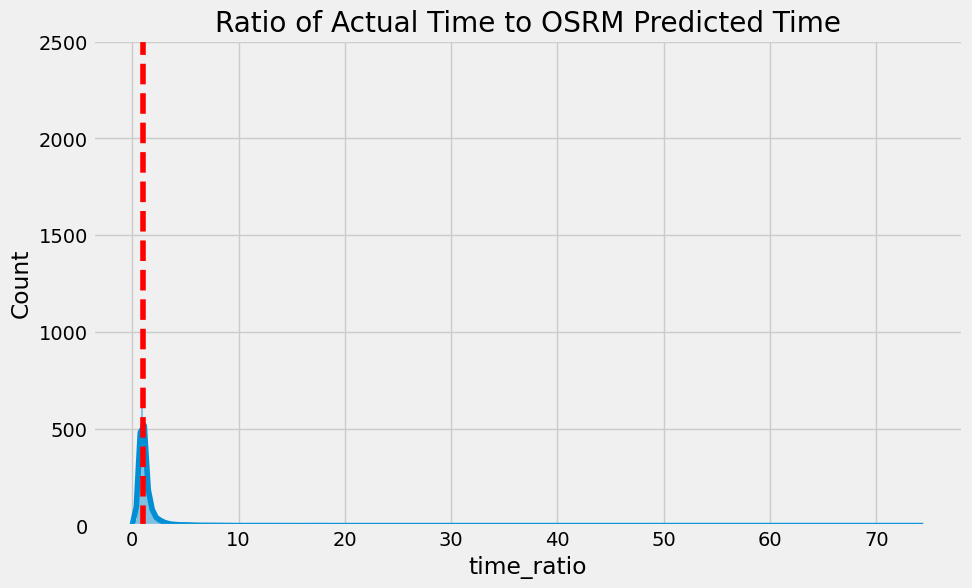

Time Ratio Statistics:


count   14817.00
mean         inf
std          NaN
min         0.00
25%         0.84
50%         1.00
75%         1.31
max          inf
Name: time_ratio, dtype: float64


57.97% of deliveries took longer than predicted by OSRM


In [96]:
if 'actual_time' in trip_df.columns and 'osrm_time' in trip_df.columns:
    # Calculate the ratio of actual to predicted time
    trip_df['time_ratio'] = trip_df['actual_time'] / trip_df['osrm_time']

    plt.figure(figsize=(10, 6))
    sns.histplot(trip_df['time_ratio'], kde=True)
    plt.axvline(x=1, color='r', linestyle='--')
    plt.title('Ratio of Actual Time to OSRM Predicted Time')
    plt.show()

    print("Time Ratio Statistics:")
    display(trip_df['time_ratio'].describe())

    # Calculate percentage of deliveries that took longer than predicted
    pct_longer = (trip_df['time_ratio'] > 1).mean() * 100
    print(f"\n{pct_longer:.2f}% of deliveries took longer than predicted by OSRM")

## **PART 7: RECOMMENDATIONS**

## **Data-Driven Strategic Recommendations for Delhivery**

### **1. Improve OSRM Time Prediction Accuracy**
- Despite a high correlation (0.9889) between Actual Time and OSRM Time, the t-test (t=32.47, p<0.001) confirms a significant difference, indicating systemic underestimation.
- Incorporate correction factors into OSRM’s time estimations to align better with observed actual times, especially where delays consistently exceed predictions (57.97% of deliveries took longer than OSRM estimates).

### **2. Prioritize Action on High-Delay Corridors**
- Corridors such as *Nagaland to Assam (414.85% delay)* and *Uttarakhand to Haryana (305.21% delay)* should be flagged for operational audits and targeted interventions.
- These outlier routes—though possibly lower in volume—pose high risk and cost if unaddressed.

### **3. Resolve Critical Segment-Level Bottlenecks**
- Top segments like *Hubli to Dharwad* and *Jangipur to Sagardighi* report astronomical delay percentages (e.g., 4205B%, likely due to data entry/processing issues or extreme delays). These require immediate root-cause investigations, as they distort overall logistics planning.

### **4. Optimize Regional Strategies Based on Corridor Efficiencies**
- *West to North* and *North to South* corridors exhibit strong performance (actual speed >0.60, time efficiency ratio >5), whereas *East to East* and *Central to Central* underperform with high delay percentages (>190%) and lower efficiency ratios (<3.5).
- Shift capacity and planning resources towards better-performing corridors and improve operational efficiency where underperformance is chronic.

### **5. Improve Mode Allocation Between Carting and FTL**
- Carting operations show significantly higher delays (162%) compared to FTL (115%) and lower actual speed (0.43 vs. 0.56).
- Focus on evaluating trip types suitable for Carting and explore conversion to FTL where possible for time-sensitive deliveries.

### **6. Leverage Time-of-Day Performance Patterns**
- Evening slots outperform others with lowest delay percentage (114%) and highest actual speed (0.51), while Morning and Night deliveries face elevated delays (~157%).
- Redesign scheduling strategies and buffer allocations around these temporal trends to improve SLA adherence.

### **7. Focus Consistency Measures on High-Variance Corridors**
- Routes like *Maharashtra to Maharashtra* and *Uttar Pradesh to Uttar Pradesh* lead in inconsistent trip counts (377 and 322 respectively) with high standard deviation in delays.
- Deploy SOPs, more granular tracking, and contingency plans to standardize performance across these volatile corridors.

### **8. Reconcile Segment vs Route Data Discrepancies**
- Despite high correlations between Segment-level and OSRM metrics (>0.9), significant statistical differences (p<0.001 in all t-tests) exist, indicating misalignment.
- Build models that reconcile segment-level deviations into route-level ETA models to enable more accurate end-to-end predictions.

# **General Strategic Recommendations for Delhivery**

## **High-Priority Actions**

1. **Address Network Bottlenecks**:
   - Allocate additional resources to the top 5 identified bottleneck segments where delays are consistently highest
   - Investigate specific factors causing delays in these segments (infrastructure, traffic, operational issues)
   - Consider alternative routing options for high-priority shipments

2. **Route Type Optimization**:
   - Adjust resource allocation between FTL and Carting based on their relative efficiency metrics
   - For routes where one transport type significantly outperforms the other, shift the mix accordingly
   - Implement specialized handling procedures for the least efficient route type combinations

3. **Time-Based Scheduling Improvements**:
   - Reschedule deliveries to avoid peak delay periods identified in the time-of-day analysis
   - Adjust buffer times in estimated delivery schedules based on time-of-day performance variations
   - Consider night-time transport for critical corridors with high daytime congestion

## **Operational Improvements**

4. **Enhance Prediction Accuracy**:
   - Update OSRM time predictions with correction factors derived from the actual vs. predicted analysis
   - Develop corridor-specific prediction models that account for regional variations
   - Implement dynamic ETA updates based on real-time segment completion data

5. **Performance Consistency Management**:
   - Establish standardized processes for the most inconsistent routes to reduce variability
   - Implement additional checkpoints and tracking for segments with high variance
   - Develop contingency plans specifically for inconsistent corridors

6. **Regional Strategy Adjustments**:
   - Develop region-specific logistics strategies based on the performance variations across regions
   - Establish specialized teams for managing challenging regional corridors
   - Consider geographic redistribution of hub locations to better serve high-demand corridors

## **Long-Term Strategic Initiatives**

7. **Data-Driven Infrastructure Investment**:
   - Prioritize infrastructure improvements in areas with consistent bottlenecks
   - Consider strategic placement of new distribution centers in underserved high-demand areas
   - Develop predictive maintenance schedules based on corridor usage patterns

8. **Partner Ecosystem Development**:
   - Form strategic partnerships with local logistics providers in challenging regions
   - Develop specialized carrier networks for high-variability corridors
   - Implement performance-based incentives for partners in critical segments

9. **Continuous Improvement Framework**:
   - Establish KPIs to track improvements in the identified problem areas
   - Implement a feedback loop for ongoing refinement of time and distance predictions
   - Develop a quarterly review process for route performance analysis
""")

## **If the outputs are not satisfactory in the PDF, please kindly check the colab**
LINK TO COLAB : https://colab.research.google.com/drive/1fwN1Cb0l6QbI2K9Q2VlxPF1H4CB9rYEf?usp=sharing

In [97]:
# Save the preprocessed dataframe for future use
trip_df.to_csv('delhivery_processed_data.csv', index=False)
print("\nPreprocessed data saved to 'delhivery_processed_data.csv'")
print("\nFin!")


Preprocessed data saved to 'delhivery_processed_data.csv'

Fin!
